# Homework 1 (Total Points: 260) <a class="anchor" id="top"></a>


**Submission instructions**:
- Only the code `TODO: Implement this!` denotes that these sections are graded.
- For Part 1: You can use the `nltk`, `numpy` and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. For Part 2: `gensim` is allowed in addition to the imported libraries in the next code cell
- The notebook you submit has to have the student ids, separated by underscores (E.g., `12341234_12341234_12341234.ipynb`). 
- This will be parsed by a regexp, so please double check your filename.
- Only one member of each group has to submit the file to canvas.
- Make sure to check that your notebook runs before submission. A quick way to do this is to restart the kernel and run all the cells.  
- Please do not delete/add new cells. Removing cells can lead to grade deduction.
- Note, that you are not allowed to use Google Colab.


**Learning Goals**:
- [Part 1, Term-based matching](#part1) (175 points):
    - Learn how to load a dataset and process it.
    - Learn how to implement several standard IR methods (TF-IDF, BM25, QL) and understand their weaknesses & strengths.
    - Learn how to evaluate IR methods.
- [Part 2, Semantic-based matching](#part2) (85 points):
    - Learn how to implement vector-space retrieval methods (LSI, LDA).
    - Learn how to use LSI and LDA for re-ranking

    
**Resources**: 
- **Part 1**: Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)
- **Part 2**: [LSI - Chapter 18](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) from [Introduction to Information Retrieval](https://nlp.stanford.edu/IR-book/) book and the [original LDA paper](https://jmlr.org/papers/volume3/blei03a/blei03a.pdf)

In [1]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:
# TODO: You can also use unlisted classes from these libraries or standard libraries (such as defaultdict, Counter, ...).

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from ipywidgets import widgets
from IPython.display import display, HTML
#from IPython.html import widgets
from collections import namedtuple

%matplotlib inline


# Part 1: Term-based Matching (175 points) <a class="anchor" id="part1"></a>

[Back to top](#top)

In the first part, we will learn the basics of IR from loading and preprocessing the material, to implementing some well known search algorithms, to evaluating the ranking performance of the implemented algorithms. We will be using the CACM dataset throughout the assignment. The CACM dataset is a collection of titles and abstracts from the journal CACM (Communication of the ACM).

Table of contents:
- [Section 1: Text Processing](#text_processing) (15 points)
- [Section 2: Indexing](#indexing) (10 points)
- [Section 3: Ranking](#ranking) (80 points)
- [Section 4: Evaluation](#evaluation) (40 points)
- [Section 5: Analysis](#analysis) (30 points)


---
## Section 1: Text Processing (15 points)<a class="anchor" id="text_processing"></a>

[Back to Part 1](#part1)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 
The points of this section are earned for the following implementations:
- `read_cacm_docs` (4 points): Reads in the CACM documents.
- `read_queries` (3 points): Reads in the CACM queries.
- `load_stopwords` (1 point): Loads the stopwords.
- `tokenize` (4 points): Tokenizes the input text.
- `stem_token` (3 points): Stems the given token. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 


---
### 1.1 Read the CACM documents (4 points)


The following cell downloads the dataset and unzips it to a local directory.

In [2]:
def download_dataset():
    folder_path = os.environ.get("IR1_DATA_PATH")
    if not folder_path:
        folder_path = "./datasets/"
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

---

You can see a brief description of each file in the dataset by looking at the README file:

In [3]:
##### Read the README file 
!cat ./datasets/README
#####

Files in this directory with sizes:
          0 Jun 19 21:01 README

    2187734 Jun 19 20:55 cacm.all              text of documents
        626 Jun 19 20:58 cite.info             key to citation info
                                                (the X sections in cacm.all)
       2668 Jun 19 20:55 common_words           stop words used by smart
       2194 Jun 19 20:55 make_coll*             shell script to make collection
       1557 Jun 19 20:55 make_coll_term*        ditto (both useless without
                                                smart system)
       9948 Jun 19 20:55 qrels.text             relation giving
                                                    qid did 0 0
                                                to indicate dument did is
                                                relevant to query qid
      13689 Jun 19 20:55 query.text             Original text of the query


---
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available. 
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [4]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
!head -45 ./datasets/cacm.all
#####

.I 1
.T
Preliminary Report-International Algebraic Language
.B
CACM December, 1958
.A
Perlis, A. J.
Samelson,K.
.N
CA581203 JB March 22, 1978  8:28 PM
.X
100	5	1
123	5	1
164	5	1
1	5	1
1	5	1
1	5	1
205	5	1
210	5	1
214	5	1
1982	5	1
398	5	1
642	5	1
669	5	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
165	6	1
196	6	1
196	6	1
1273	6	1
1883	6	1
324	6	1
43	6	1
53	6	1
91	6	1
410	6	1
3184	6	1


---

**Implementation (4 points):**
Write a function to read the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document:

In [5]:
# TODO: Implement this! (4 points)
def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/" by default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (separated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
    # YOUR CODE HERE
    
    file_location = os.path.join(root_folder, "cacm.all")

    doclist = []

    with open(file_location, "r") as f:
        docs = [("I\n" + x) for x in f.read().split(".I ")]

    docs = docs[1:]
    docs_fields = [["." + x for x in doc.split("\n.")] for doc in docs]

    for doc in docs_fields:
        abstract = ""
        for field in doc:
            if field.startswith('.I\n') == True:
                doc_id = field[3:]
            elif field.startswith('.T\n') == True:
                title = field[3:]
            elif field.startswith('.W\n') == True:
                abstract = "\n" + field[3:]
        document = title + abstract
        doclist.append((int(doc_id), document))
    
    return doclist
    
    raise NotImplementedError()

In [6]:
##### Function check
docs = read_cacm_docs()

assert isinstance(docs, list)
assert len(docs) == 3204, "There should be exactly 3024 documents"
##### 

---
### 1.2 Read the CACM queries (3 points)

Next, let us read the queries. They are formatted similarly:

In [7]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
!head -15 ./datasets/query.text
#####

.I 1
.W
 What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
.N
 1. Richard Alexander, Comp Serv, Langmuir Lab (TSS)
 
.I 2
.W
 I am interested in articles written either by Prieve or Udo Pooch
.A
Prieve, B.
Pooch, U.
.N
 2. Richard Alexander, Comp Serv, Langmuir Lab (author = Pooch or Prieve)


---

**Implementation (3 points):**
Write a function to read the `query.text` file:

In [8]:
# TODO: Implement this! (3 points)
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" by default
        Returns: A list of 2-tuples: (query_id, query)
    """
    # YOUR CODE HERE
    
    file_location = os.path.join(root_folder, "query.text")

    querylist = []

    with open(file_location, "r") as f:
        queries = [("I\n" + x) for x in f.read().split(".I ")]

    queries = queries[1:]
    query_fields = [["." + x for x in query.split("\n.")] for query in queries]

    for query in query_fields:
        for field in query:
            if field.startswith('.I\n') == True:
                query_id = field[3:]
            elif field.startswith('.W\n') == True:
                query_w = field[3:]
        querylist.append((int(query_id), query_w))
    
    return querylist
    
    raise NotImplementedError()


In [9]:
##### Function check
queries = read_queries()

assert isinstance(queries, list)
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"
##### 

---
### 1.3 Read the stop words (1 point)

We use the common words stored in `common_words`:

In [10]:
##### Read the stop words file 
!head ./datasets/common_words
##### Read the README file 

a
about
above
accordingly
across
after
afterwards
again
against
all


---
**Implementation (1 point):**
Write a function to read the `common_words` file (For better coverage, try to keep them in lowercase):

In [11]:
# TODO: Implement this! (1 point)
def load_stopwords(root_folder = "./datasets/"):
    """
        Loads the stopwords. The dataset is assumed to be in the folder "./datasets/" by default
        Output: A set of stopwords
    """
    # YOUR CODE HERE
    
    file_location = os.path.join(root_folder, "common_words")

    with open(file_location, "r") as f:
        stopwords = {x for x in f.read().lower().split("\n") if x != ""}
    
    return stopwords

    raise NotImplementedError()


In [12]:
##### Function check
stopwords = load_stopwords()

assert isinstance(stopwords, set)
assert len(stopwords) == 428, "There should be exactly 428 stop words"
##### 

---
### 1.4 Tokenization (4 points)

We can now write some basic text processing functions. 
A first step is to tokenize the text. 

**Note**: Use the  `WordPunctTokenizer` available in the `nltk` library:

In [13]:
# TODO: Implement this! (4 points)
def tokenize(text):
    """
        Tokenizes the input text. Use the WordPunctTokenizer
        Input: text - a string
        Output: a list of tokens
    """
    # YOUR CODE HERE
    
    tokens = nltk.tokenize.WordPunctTokenizer().tokenize(text)
    
    return tokens
    
    raise NotImplementedError()

In [14]:
##### Function check
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenize(text)

assert isinstance(tokens, list)
assert len(tokens) == 9

print(tokens)
# output: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


---
### 1.5 Stemming (3 points)

Write a function to stem tokens. 
Again, you can use the nltk library for this:

In [15]:
# TODO: Implement this! (3 points)
def stem_token(token):
    """
        Stems the given token using the PorterStemmer from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    # YOUR CODE HERE
    
    stem = nltk.stem.porter.PorterStemmer().stem(token)
    
    return stem
    
    raise NotImplementedError()

In [16]:
##### Function check

assert stem_token('owned') == 'own'
assert stem_token('itemization') == 'item'
#####

---
### 1.6 Summary

The following function puts it all together. Given a string, it tokenizes it and processes it according to the flags that you set.

In [17]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

---

Let's create two sets of preprocessed documents.
We can process the documents and queries according to these two configurations:

In [18]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text, stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 

####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))

####

--- 

## Section 2: Indexing (10 points)<a class="anchor" id="indexing"></a>

[Back to Part 1](#part1)



A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


### 2.1 Term Frequency-index (10 points)
In this assignment, we will be using an index created in memory since our dataset is tiny. To get started, build a simple index that maps each `token` to a list of `(doc_id, count)` where `count` is the count of the `token` in `doc_id`.
For consistency, build this index using a python dictionary.
    
Now, implement a function to build an index:

In [19]:
# TODO: Implement this! (10 points)
def build_tf_index(documents):
    """
        Build an inverted index (with counts). The output is a dictionary which takes in a token
        and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
        Input: a list of documents - (doc_id, tokens) 
        Output: An inverted index. [token] -> [(doc_id, token_count)]
    """
    # YOUR CODE HERE
    
    from collections import defaultdict
    
    index = defaultdict(str)

    for (doc_id, tokens) in documents:
        unique_tokens = set(tokens)
        for word in unique_tokens:
            count_word = int(tokens.count(word))
            if word not in index.keys():
                index[word] = [(doc_id, count_word)]
            else:
                index[word].append((doc_id, count_word))
    
    return index

    raise NotImplementedError()

---
Now we can build indexed documents and preprocess the queries based on the two configurations:

In [20]:
#### Indexed documents based on the two configs

# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

# This function returns the tf_index of the corresponding config
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]

####
#### Preprocessed query based on the two configs

# This function preprocesses the text given the index set, according to the specified config
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)

#### 

In [21]:
##### Function check

print(tf_index_1['computer'][:10])
#### 

[(4, 1), (7, 1), (10, 1), (13, 1), (19, 1), (22, 1), (23, 1), (37, 1), (40, 3), (41, 1)]


In [22]:
##### Function check

print(tf_index_2['computer'][:10])
#### 

[(670, 1), (675, 1), (1621, 3), (1681, 1), (2145, 1), (2339, 1), (2572, 1), (2583, 1), (2739, 1), (3012, 1)]



---
## Section 3: Ranking  (80 points) <a class="anchor" id="ranking"></a>

[Back to Part 1](#part1)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- [Section 3.1: Bag of Words](#bow) (10 points)
- [Section 3.2: TF-IDF](#tfidf) (15 points)
- [Section 3.3: Query Likelihood Model](#qlm) (35 points)
- [Section 3.4: BM25](#bm25) (20 points)

**Scoring policy:**
Your implementations in this section are scored based on the expected performance of your ranking functions.
You will get a full mark if your implementation meets the expected performance (measured by some evaluation metric).
Otherwise, you may get partial credit.
For example, if your *Bag of words* ranking function has 60% of expected performance, you will get 4 out of 10.

--- 

### Section 3.1: Bag of Words (10 points)<a class="anchor" id="bow"></a>

Probably the simplest IR model is the Bag of Words (BOW) model.
Implement a function that scores and ranks all the documents against a query using this model.   

Note that you can use either the count of the token or 'binarize' it i.e set the value equal to 1 if the token appears.   


In [23]:
# TODO: Implement this! (10 points)
def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note: You have to use the `get_index` function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    processed_query = preprocess_query(query, index_set)
    
    # YOUR CODE HERE
    
    query_score = []
    
    for query_word in processed_query:
        for key, value in index.items():
            if query_word == key:
                bow_value = [(doc_id, 1) for doc_id, token_count in value]
                query_score.extend(bow_value)
    
    dict_query = dict()
    for (key, value) in query_score:
        if key in dict_query:
            dict_query[key] += value
        else:
            dict_query[key] = value

    query_score = [(k, float(v)) for k, v in dict_query.items()]
    query_score.sort(key=lambda x:x[1], reverse=True)
    
    return query_score
    
    raise NotImplementedError()

In [24]:
#### Function check

docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow = bow_search("report", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow)
#### 

BOW Results:
Rank 0(1.0): Preliminary Report-International Algebraic Languag...
Rank 1(1.0): ALGOL Sub-Committee Report - Extensions...
Rank 2(1.0): The Use of Computers in Engineering Classroom Inst...
Rank 3(1.0): Report on a Conference of University Computing Cen...
Rank 4(1.0): Report on the Algorithmic Language ALGOL 60...


In [25]:
#### Please do not change this. This cell is used for grading.

In [26]:
#### Please do not change this. This cell is used for grading.

In [27]:
#### Please do not change this. This cell is used for grading.


---

### Section 3.2: TF-IDF (15 points) <a class="anchor" id="tfidf"></a>

Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

#### 3.2.1 Document frequency (5 points)
Compute the document frequencies of all tokens in the collection.  

In [28]:
# TODO: Implement this! (5 points)
def compute_df(documents):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency)
    """
    # YOUR CODE HERE
    
    doc_freq = {}
    
    for doc in documents:
        for word in set(doc):
            if word not in doc_freq.keys():
                doc_freq[word] = 1
            else:
                doc_freq[word] += 1
                
    return doc_freq
    
    raise NotImplementedError()


In [29]:
#### Compute df based on the two configs

# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]
####

In [30]:
#### Function check

print(df_1['computer'])
print(df_2['computer'])
####

597
11


---
#### 3.2.2 TF-IDF search (10 points)
Next, implement a function that computes a tf-idf score given a query.      

In [31]:
# TODO: Implement this! (10 points)
def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    df = get_df(index_set)
    processed_query = preprocess_query(query, index_set)
    
    # YOUR CODE HERE
    
    total_docs = len(docs)
    idf = {key: np.log(total_docs / value) for (key, value) in df.items()}

    query_score = []
    
    for query_word in processed_query:
        for key, value in index.items():
            if query_word == key:
                tfidf_value = [(doc_id, token_count * idf[key]) for doc_id, token_count in value]
                query_score.extend(tfidf_value)
    
    dict_query = dict()
    for (key, value) in query_score:
        if key in dict_query:
            dict_query[key] += value
        else:
            dict_query[key] = value
            
    query_score = [(k, float(v)) for k, v in dict_query.items()]
    query_score.sort(key=lambda x:x[1], reverse=True)
    
    return query_score
    
    raise NotImplementedError()

In [32]:
#### Function check
test_tfidf = tfidf_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf)
####

TFIDF Results:
Rank 0(2.3e+01): An Information Algebra - Phase I Report-Language\n...
Rank 1(2.3e+01): Rejuvenating Experimental Computer Science\nThis r...
Rank 2(1.2e+01): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(7.8): Automatic Abstracting and Indexing Survey and Reco...
Rank 4(7.8): A String Language for Symbol Manipulation Based on...


In [33]:
#### Please do not change this. This cell is used for grading.

In [34]:
#### Please do not change this. This cell is used for grading.

In [35]:
#### Please do not change this. This cell is used for grading.

--- 

### Section 3.3: Query Likelihood Model (35 points) <a class="anchor" id="qlm"></a>

In this section, you will implement a simple query likelihood model. 


#### 3.3.1 Naive QL (15 points)

First, let us implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 



In [36]:
#### Document length for normalization

def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

In [37]:
# TODO: Implement this! (15 points)
def naive_ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    processed_query = preprocess_query(query, index_set)
    
    # YOUR CODE HERE
    
    query_score = []
    
    for query_word in processed_query:
        for key, value in index.items():
            if query_word == key:
                nql_value = [(doc_id, token_count / doc_lengths[doc_id]) for doc_id, token_count in value]
                query_score.extend(nql_value)
                
                doc_contains = [doc_id for doc_id, token_count in value]
                for i in range(len(docs)):
                    i += 1
                    if i not in doc_contains:
                        query_score.append((i, 0))
    
    dict_query = dict()
    for (key, value) in query_score:
        if key in dict_query:
            dict_query[key] *= value
        else:
            dict_query[key] = value

    query_score = [(k, float(v)) for k, v in dict_query.items()]
    query_score.sort(key=lambda x:x[1], reverse=True)
    
    return query_score
    
    raise NotImplementedError()

In [38]:
#### Function check
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"Naive QL Results:")
print_results(test_naiveql)
####

Naive QL Results:
Rank 0(0.2): A Report Writer For COBOL...
Rank 1(0.2): A CRT Report Generating System...
Rank 2(0.17): Preliminary Report-International Algebraic Languag...
Rank 3(0.17): Supplement to the ALGOL 60 Report...
Rank 4(0.14): ALGOL Sub-Committee Report - Extensions...


In [39]:
#### Please do not change this. This cell is used for grading.

In [40]:
#### Please do not change this. This cell is used for grading.

In [41]:
#### Please do not change this. This cell is used for grading.

In [42]:
#### Please do not change this. This cell is used for grading.

---
#### 3.3.2 QL (20 points)
Now, let's implement a QL model that handles the issues with the naive version. In particular, you will implement a QL model with Jelinek-Mercer Smoothing. That means an interpolated score is computed per word - one term is the same as the previous naive version, and the second term comes from a unigram language model. In addition, you should accumulate the scores by summing the **log** (smoothed) probability which leads to better numerical stability.

In [43]:
# TODO: Implement this! (20 points)

# YOUR CODE HERE

#raise NotImplementedError()

def ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a QL model 
        with Jelinek-Mercer Smoothing (set smoothing=0.1). 
        
        
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        
        
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    processed_query = preprocess_query(query, index_set)
    
    # YOUR CODE HERE
    
    sm = 0.1
    rsm = 1 - 0.1
    
    coll_freq = {k: sum(count for doc_id, count in value) for k, value in index.items()}
    coll_length = sum(doc_lengths.values()) 
    
    query_score = []
    
    for query_word in processed_query:
        for key, value in index.items():
            if query_word == key:
                ql_value = [(doc_id,
                             np.log(rsm*(tkn_ct/doc_lengths[doc_id]) + sm*(coll_freq[key]/coll_length))) for doc_id, tkn_ct in value]
                query_score.extend(ql_value)
                
                doc_contains = [doc_id for doc_id, token_count in value]
                for i in range(len(docs)):
                    i += 1
                    if i not in doc_contains:
                        query_score.append((i, np.log(0 + sm*(coll_freq[key]/coll_length))))
    
    dict_query = dict()
    for (key, value) in query_score:
        if key in dict_query:
            dict_query[key] += value
        else:
            dict_query[key] = value

    query_score = [(k, float(v)) for k, v in dict_query.items()]
    query_score.sort(key=lambda x:x[1], reverse=True)
    
    return query_score
    
    raise NotImplementedError()
    

In [44]:
#### Function check
test_ql_results = ql_search("report", index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(-1.7): A Report Writer For COBOL...
Rank 1(-1.7): A CRT Report Generating System...
Rank 2(-1.9): Preliminary Report-International Algebraic Languag...
Rank 3(-1.9): Supplement to the ALGOL 60 Report...
Rank 4(-2.1): ALGOL Sub-Committee Report - Extensions...

Rank 0(-1.7e+01): A Report Writer For COBOL...
Rank 1(-1.7e+01): A CRT Report Generating System...
Rank 2(-1.9e+01): Preliminary Report-International Algebraic Languag...
Rank 3(-1.9e+01): Supplement to the ALGOL 60 Report...
Rank 4(-2.1e+01): ALGOL Sub-Committee Report - Extensions...


In [45]:
#### Please do not change this. This cell is used for grading.

In [46]:
#### Please do not change this. This cell is used for grading.

In [47]:
#### Please do not change this. This cell is used for grading.

In [48]:
#### Please do not change this. This cell is used for grading.

--- 

### Section 3.4: BM25 (20 points) <a class="anchor" id="bm25"></a>

In this section, we will implement the BM25 scoring function. 


In [49]:
# TODO: Implement this! (20 points)
def bm25_search(query, index_set):
    """
        Perform a search over all documents with the given query using BM25. Use k_1 = 1.5 and b = 0.75
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    index = get_index(index_set)
    df = get_df(index_set)
    doc_lengths = get_doc_lengths(index_set)
    processed_query = preprocess_query(query, index_set)
    
    # YOUR CODE HERE
    
    k1 = 1.5
    b = 0.75
    k2 = k1 + 1
    b2 = 1 - b
    
    total_docs = len(docs)
    avg_dl = np.mean(list(doc_lengths.values()))
    idf = {key: np.log(total_docs / value) for (key, value) in df.items()}

    query_score = []
    
    for query_word in processed_query:
        for key, value in index.items():
            if query_word == key:
                bm_value = [(doc_id, idf[key] * ((k2*tkn_ct)/(k1*(b2+(b*doc_lengths[doc_id]/avg_dl))+tkn_ct))) for doc_id, tkn_ct in value]
                query_score.extend(bm_value)
    
    dict_query = dict()
    for (key, value) in query_score:
        if key in dict_query:
            dict_query[key] += value
        else:
            dict_query[key] = value
            
    query_score = [(k, float(v)) for k, v in dict_query.items()]
    query_score.sort(key=lambda x:x[1], reverse=True)
    
    return query_score
    
    raise NotImplementedError()

In [50]:
#### Function check
test_bm25_results = bm25_search("report", index_set=1)[:5]
print_results(test_bm25_results)
####

Rank 0(6.7): A Report Writer For COBOL...
Rank 1(6.7): A CRT Report Generating System...
Rank 2(6.6): Preliminary Report-International Algebraic Languag...
Rank 3(6.6): Supplement to the ALGOL 60 Report...
Rank 4(6.5): ALGOL Sub-Committee Report - Extensions...


In [51]:
#### Please do not change this. This cell is used for grading.

In [52]:
#### Please do not change this. This cell is used for grading.

In [53]:
#### Please do not change this. This cell is used for grading.

In [54]:
#### Please do not change this. This cell is used for grading.


---

### 3.5. Test Your Functions

The widget below allows you to play with the search functions you've written so far. Use this to test your search functions and ensure that they work as expected.

In [55]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

In [56]:
# TODO: Set this to the function you want to test!
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search
index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

Text(value='', description='Search Bar')

---

## Section 4: Evaluation (40 points) <a class="anchor" id="evaluation"></a>

[Back to Part 1](#part1)

Before we jump in and implement an algorithm for retrieval, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision (7 points)
2. Recall (7 points)
3. Mean Average Precision (12 points)
4. Expected Reciprocal Rank (12 points)

---
### 4.1 Read relevance labels (2 points)

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [57]:
!head ./datasets/qrels.text

01 1410  0 0
01 1572  0 0
01 1605  0 0
01 2020  0 0
01 2358  0 0
02 2434  0 0
02 2863  0 0
02 3078  0 0
03 1134  0 0
03 1613  0 0


---
**Implementation (2 points):**
The first column is the query_id and the second column is the document_id. You can safely ignore the 3rd and 4th columns. Write a function to read in the file:

In [58]:
# TODO: Implement this! (2 points)
def read_qrels(root_folder = "./datasets/"):
    """
        Reads the qrels.text file. 
        Output: A dictionary: query_id -> [list of relevant documents]
    """
    # YOUR CODE HERE
    
    file_location = os.path.join(root_folder, "qrels.text")

    relevant_docs = {}
    
    with open(file_location, "r") as f:
        lines = f.readlines()
    
    qrels = []
    
    for line in lines:
        items_line = line.split(' ')
        qrels.append((int(items_line[0].lstrip('0')), int(items_line[1].lstrip('0'))))
        
    for x, y in qrels:
        relevant_docs.setdefault(x, []).append(y)
    
    return relevant_docs
    
    raise NotImplementedError()


In [59]:
#### Function check
qrels = read_qrels()

assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"
####

---
**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


---
### 4.2 Precision (7 points)
Implement the `precision@k` metric:

In [60]:
# TODO: Implement this! (7 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """
    # YOUR CODE HERE  
    
    return np.sum([1 for y in [x[0] for x in results[:k]] if y in relevant_docs])/k
    
    raise NotImplementedError()

In [61]:
#### Function check
qid = queries[0][0]
qtext = queries[0][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
precision = precision_k(results, qrels[qid], 10)
print(f'precision@10 = {precision}')
####

query: What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
precision@10 = 0.2


---
### 4.3 Recall (7 points)
Implement the `recall@k` metric:

In [62]:
# TODO: Implement this! (7 points)
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    # YOUR CODE HERE
    
    to_return = np.sum([1 for y in [x[0] for x in  results[:k]] if y in relevant_docs])/len(relevant_docs)
    
    return to_return
    
    raise NotImplementedError()

In [63]:
#### Function check
qid = queries[10][0]
qtext = queries[10][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
recall = recall_k(results, qrels[qid], 10)
print(f'recall@10 = {recall}')
####

query: SETL, Very High Level Languages
recall@10 = 0.3157894736842105


---
### 4.4 Mean Average Precision (12 points)
Implement the `map` metric:

In [64]:
# TODO: Implement this! (12 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    # YOUR CODE HERE
    
    position_k={}
    
    for i in range(1,len(results)+1,1):
        position_k[i]=precision_k(results, relevant_docs, i)
        
    index=[]
    for i,j in enumerate(results):
         if j[0] in relevant_docs:
            index.append(i+1)
            
    if len(index)>0:
        return sum([position_k[x] for x in index])/len(index)
    else:
        return 0
    
    raise NotImplementedError()


In [65]:
#### Function check
qid = queries[20][0]
qtext = queries[20][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
mean_ap = average_precision(results, qrels[qid])
print(f'MAP = {mean_ap}')
####

query: computational complexity, intractability, class-complete reductions,
algorithms and efficiency
MAP = 0.17269233631989397


---
### 4.5 Expected Reciprocal Rank (12 points)
Implement the `err` metric:

In [66]:
# TODO: Implement this! (12 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
        
    """
    # YOUR CODE HERE
    
    max_grade = 1.0
    step_down = 1.0
    error = 0.0

    for i, (doc_id, score) in enumerate(results):
        grade = 1. if doc_id in relevant_docs else 0.
        t = (pow(2, grade) - 1) / pow(2, max_grade)
        error += step_down * (t / (i + 1.))
        step_down *= (1. - t)
        
    return error
    
    raise NotImplementedError()

In [67]:
#### Function check
qid = queries[30][0]
qtext = queries[30][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
ERR = err(results, qrels[qid])
print(f'ERR = {ERR}')
####

query: I'd like to find articles describing the use of singular value decomposition
in digital image processing.  Applications include finding approximations
to the original image and restoring images that are subject to noise. An
article on the subject is H.C. Andrews and C.L. Patterson "Outer product
expansions and their uses in digital image processing", American Mathematical
Monthly, vol. 82.
ERR = 0.625


---
### 4.6 Evaluate Search Functions

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [68]:
#### metrics@k functions

recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)


list_of_metrics = [
    ("ERR", err),
    ("MAP", average_precision),
    ("Recall@1",recall_at_1),
    ("Recall@5", recall_at_5),
    ("Recall@10", recall_at_10),
    ("Precision@1", precision_at_1),
    ("Precision@5", precision_at_5),
    ("Precision@10", precision_at_10)]
####

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [69]:
#### Evaluate a search function

list_of_search_fns = [
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search),
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search)
]

def evaluate_search_fn(search_fn, metric_fns, index_set=None):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = {}
    for metric, metric_fn in metric_fns:
        metrics[metric] = np.zeros(len(qrels), dtype=np.float32)
    
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        if index_set:
            results = search_fn(query, index_set)
        else:
            results = search_fn(query)
        
        for metric, metric_fn in metric_fns:
            metrics[metric][i] = metric_fn(results, relevant_docs)

    
    
    final_dict = {}
    for metric, metric_vals in metrics.items():
        final_dict[metric] = metric_vals.mean()
    
    return final_dict
####

## Section 5: Analysis (30 points) <a class="anchor" id="analysis"></a>

[Back to Part 1](#part1)

In the final section of Part1, we will compare the different term-based IR algorithms and different preprocessing configurations and analyze their advantages and disadvantages.

### Section 5.1: Plot (20 points)

First, gather the results. The results should consider the index set, the different search functions and different metrics. Plot the results in bar charts, per metric, with clear labels.

**Rubric:**
- Each Metric is plotted: 7 points
- Each Method is plotted: 7 points
- Clear titles, x label, y labels and legends (if applicable): 6 points

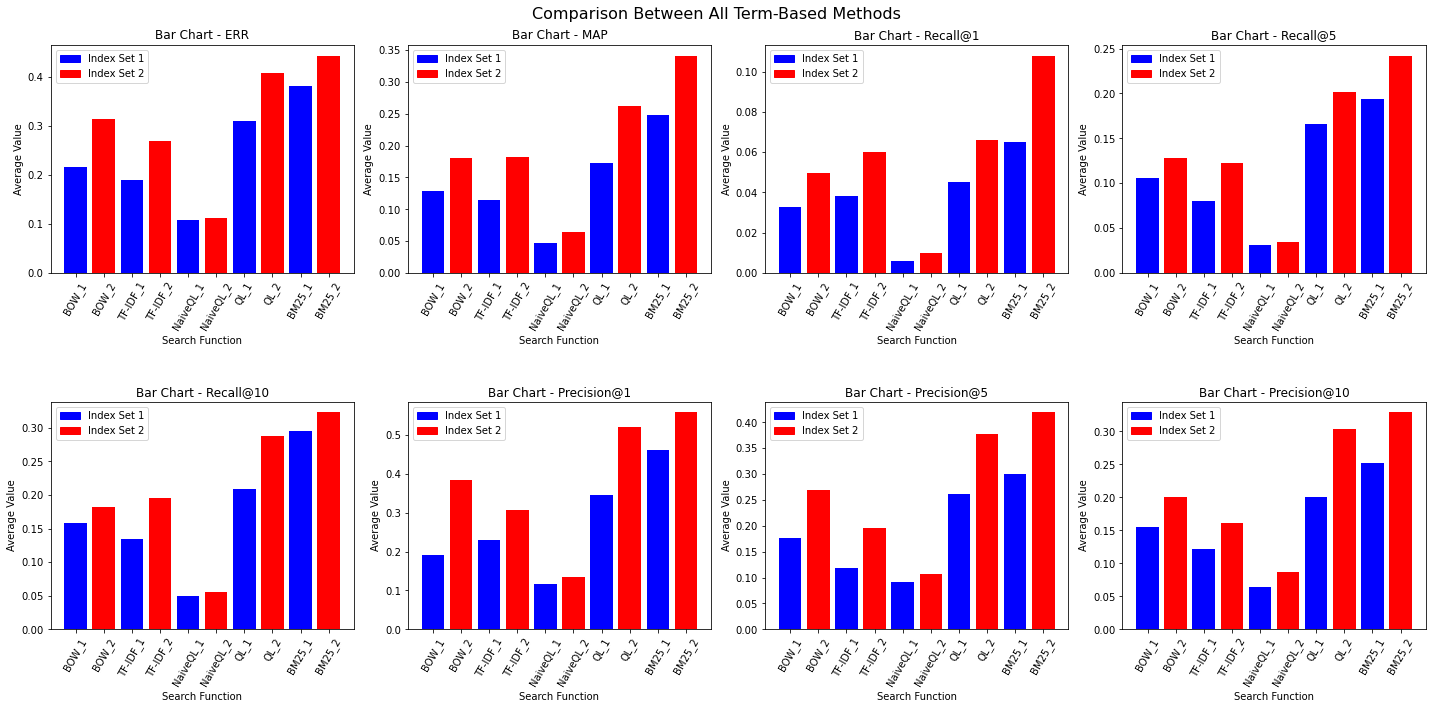

In [70]:
# YOUR CODE HERE

results_search_fns = {}

for search, search_fn in list_of_search_fns:
    for i in range(2):
        i += 1
        results_search_fns[f'{search}_{i}'] = evaluate_search_fn(search_fn, list_of_metrics, i)

#raise NotImplementedError()

fig = plt.figure(figsize=(20,10))
fig.suptitle('Comparison Between All Term-Based Methods', fontsize=16)
colors_index = {'Index Set 1':'b', 'Index Set 2':'r'}

for i, (selected_metric, funct) in enumerate(list_of_metrics):
    results_fn = []
    for (search_fn, results) in results_search_fns.items():
        for metric, value in results.items():
            if metric == selected_metric and search_fn.endswith('1'):
                results_fn.append((search_fn, value, 'Index Set 1'))
            elif metric == selected_metric and search_fn.endswith('2'):
                results_fn.append((search_fn, value, 'Index Set 2'))
    cols = np.array([colors_index[val[2]] for val in results_fn])
    title = f'Bar Chart - {selected_metric}'
    fig.add_subplot(2,4,i+1)
    plt.bar(range(len(results_fn)), [val[1] for val in results_fn], color=cols)
    plt.xticks(range(len(results_fn)), [val[0] for val in results_fn])
    plt.xticks(rotation=60)
    plt.xlabel('Search Function')
    plt.ylabel('Average Value')
    labels=list(colors_index.keys())
    plt.legend(handles=[plt.Rectangle((0,0),1,1, color=colors_index[label]) for label in labels], labels=labels)
    plt.title(title)

plt.tight_layout(h_pad=4)
plt.show()

---
### Section 5.2: Summary (10 points)
Write a summary of what you observe in the results.
Your summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      

As shown in the bar charts plotted above, the search function that performs the best across all the metrics for both index sets is BM25. The second best-performing search function overall is QL with Jelinek-Mercer Smoothing. 
On the other hand, the search function that performs the worst across all the metrics for both index sets is the Naive QL model. The TF-IDF and the Bag of Words models seem to perform similarly, with one performing slightly better than the other depending on what metric is used to evaluate the results.

These results are consistent with what was expected, since BM25 is one of the most popular and effective ranking algorithms as stated by Croft et al. (2010), even if it consists of an empirical model. Furthermore, QL with Jelinek-Mercer Smoothing also performs well because the main issue with Naive QL models is addressed by introducing a smoothing term that prevents documents from getting a score of zero if any words in the query are missing from the document.
BOW and TF-IDF, which are older retrieval models, are much simpler in terms of how weights are calculated. Additionally, the overlap score measure was used for these two methods instead of vector similarity, which is much simpler as well. These are some of the reasons that explain why BOW and TF-IDF perform worse than other methods; although it has to be noted that TF-IDF performs better than Naive QL due to introducing IDF, a metric that gives a higher score to terms that occur in less documents. As such, TF-IDF gives a higher score to the documents for which the matching terms have a high frequency within the document but that are only present in a small number of documents. Instead, the Bag of Words model considered performed significantly better than Naive QL and also similarly to TF-IDF since it uses a binary scoring approach (i.e. it gives a score of 1 if the document contains a word or else a score of 0 in the absence of the word) rather than applying term frequency directly, which was found to give much poorer results overall than using a binary scoring system. 
With regards to Naive QL, it was expected for this method to perform worse than other methods because if any of the query words are missing from the document, then the score given to the document by this method is zero; which is clearly not a desired approach for longer queries such as the ones considered in this assignment. 

For all the methods, index set 2 gives better evaluation results than index set 1. This is what was expected as well, since additional text pre-processing in the form of removing stopwords and stemming was performed on index set 2; whereas index set 1 was only tokenized and changed to lowercase letters. For basic search engine models such as the one built in this assignment, pre-processing seems to be generally beneficial. For instance, it is evident how transforming words into their root form (stemming) would be useful in search and retrieval systems in order to find documents by matching not only exact words but also words that are semantically similar to the words in the query. Furthermore, since the search functions used are term-based retrieval functions based on term statistics such as term frequency; removing stopwords that are extremely frequent but that do not have a lot of meaning nor are a good indicator of a document's relevance assists in retrieving documents that are more relevant to the query itself and thus improves retrieval effectiveness.

With regards to the metrics, it is difficult to evaluate what metric is best in order to evaluate a retrieval system because their suitability depends on the particular scenario and the specific search task that are chosen to optimise. 
However, it can be observed that recall@1 values are much lower than the average values for other metrics for all search functions and indeces. This is due to the fact that recall evaluates whether all the possible relevant documents are in the top k predictions, regardless of the position at which they are situated; which is impossible to accomplish if only recall@1 is considered and there is more than 1 relevant document per query as is the case with most of the queries in this assignment. Recall values generally increase for all search functions as more items are considered (i.e. k increases) since it makes it possible for more relevant documents to be retrieved.
On the other hand, precision@1 is high in comparison to other metrics because it only checks whether the first result is relevant or not, hence, it can only give a value of 0 (top 1 result is not relevant) or 1 (top 1 result is relevant). When this is averaged across all the queries, it leads to higher results than other metrics if there are more 1s that 0s. For instance, an average precision@1 of 0.5 means that for half of the queries, the top 1 result is a relevant document. The only search functions that obtain higher than 0.5 average precision@1 values are QL and BM25 for index set 2, which are also the best-performing functions and index set overall as metioned above.
Other metrics such as ERR and MAP are not as easy to compare between each other and interpret as they also take into account the position of the relevant documents in the rank, resulting in higher scores if the relevant documents are higher up in the rank.

---
---
# Part 2: Semantic-based Matching (85 points) <a class="anchor" id="part2"></a>

[Back to top](#top)

We will now experiment with methods that go beyond lexical methods like TF-IDF, which operate at the word level and are high dimensional and sparse, and look at methods which constructs low dimensional dense representations of queries and documents. 

Since these low-dimensional methods have a higher time complexity, they are typically used in conjunction with methods like BM-25. That is, instead of searching through potentially million documents to find matches using low dimensional vectors, a list of K documents are retrieved using BM25, and then **re-ranked** using the other method. This is the method that is going to be applied in the following exercises. 

LSI/LDA takes documents that are similar on a semantic level - for instance, if they are describing the same topic - and projects them into nearby vectors, despite having low lexical overlap.

In this assignment, you will use `gensim` to create LSI/LDA models and use them in re-ranking. 

**Note**: The following exercises only uses `doc_repr_2` and `config_2`

Table of contents:
- [Section 6: LSI](#lsi) (15 points)
- [Section 7: LDA](#lda) (10 points)
- [Section 8: Word2Vec/Doc2Vec](#2vec) (20 points)
- [Section 8: Re-ranking](#reranking) (10 points)
- [Section 9: Re-ranking Evaluation](#reranking_eval) (30 points)

---
## Section 6: Latent Semantic Indexing (LSI) (15 points) <a class="anchor" id="lsi"></a>

[Back to Part 2](#part2)

LSI is one of the methods to embed the queries and documents into vectors. It is based on a method similar to Principal Component Analysis (PCA) for obtaining a dense concept matrix out of the sparse term-document matrix.

See [wikipedia](https://en.wikipedia.org/wiki/Latent_semantic_analysis), particularly [#Mathematics_of_LSI](https://en.wikipedia.org/wiki/Latent_semantic_analysis#Mathematics_of_LSI).

In [71]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LsiModel, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import downloader as g_downloader
# gensim uses logging, so set it up 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

---
### Section 6.1: Cosine Similarity (5 points)<a class="anchor" id="cosing_sim"></a>
Before we begin, let us first define our method of similarity for the LSI model, the cosine similarity:

$$\text{similarity} = \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

Since we are using gensim, the types of vectors returned by their classes are of the form defined below (they are not just simple vectors):

In [72]:
# 1, 2, 3 are either latent dimensions (LSI), or topics (LDA)
# The second value in each tuple is a number (LSI) or a probability (LDA)  
example_vec_1 = [(1, 0.2), (2, 0.3), (3, 0.4)]
example_vec_2 = [(1, 0.2), (2, 0.7), (3, 0.4)]

---
**Implementation (2+3 points):**
Now, implement the `dot product` operation on these types of vectors and using this operator, implement the `cosine similarity` (don't forget: two functions to implement!):

In [73]:
# TODO: Implement this! (2 points)
def dot(vec_1,vec_2): 
    """
        vec_1 and vec_2 are of the form: [(int, float), (int, float), ...]
        Return the dot product of two such vectors, computed only on the floats
        You can assume that the lengths of the vectors are the same, and the dimensions are aligned 
            i.e you won't get: vec_1 = [(1, 0.2)] ; vec_2 = [(2, 0.3)] 
                                (dimensions are unaligned and lengths are different)
    """
    # YOUR CODE HERE
    
    vec_1 = list(list(zip(*vec_1))[1])
    vec_2 = list(list(zip(*vec_2))[1])
    dot_product = np.dot(vec_1,vec_2)
    return dot_product
    
    raise NotImplementedError()


# TODO: Implement this! (3 points)
def cosine_sim(vec_1, vec_2):
    # YOUR CODE HERE
    
    cosine = dot(vec_1,vec_2)/(np.sqrt(dot(vec_1,vec_1))*np.sqrt(dot(vec_2,vec_2)))
    if np.isnan(cosine):
        return 0.0
    else:
        return cosine
    
    raise NotImplementedError()

In [74]:
##### Function check
print(f'vectors: {(example_vec_1,example_vec_2)}')
print(f'dot product = {dot(example_vec_1,example_vec_2)}')
print(f'cosine similarity = {cosine_sim(example_vec_1,example_vec_2)}')
##### 

vectors: ([(1, 0.2), (2, 0.3), (3, 0.4)], [(1, 0.2), (2, 0.7), (3, 0.4)])
dot product = 0.41000000000000003
cosine similarity = 0.9165587597202866


In [75]:
#### Please do not change this. This cell is used for grading.

---
### Section 6.2: LSI Retrieval (10 points)<a class="anchor" id="lsi_retrieval"></a>
LSI retrieval is simply ranking the documents based on their cosine similarity to the query vector.
First, let's write a parent class for vector-based retrieval models:

In [76]:
class VectorSpaceRetrievalModel:
    """
        Parent class for Dense Vector Retrieval models
    """
    def __init__(self, doc_repr):
        """
            document_collection: 
                [
                    (doc_id_1, [token 1, token 2, ...]), 
                    (doc_id_2, [token 1, token 2, ....]) 
                    ...
                ]

        """
        self.doc_repr = doc_repr
        self.documents = [_[1] for _ in self.doc_repr]
        
        # construct a dictionary
        self.dictionary = Dictionary(self.documents)
        # Filter out words that occur less than 20 documents, or more than 50% of the documents.
        self.dictionary.filter_extremes(no_below=10)
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.documents]
    
        # Make a index to word dictionary.
        temp = self.dictionary[0]  # This is only to "load" the dictionary.
        self.id2word = self.dictionary.id2token
        
        # this is set by the train_model function
        self.model = None
        
        
    def vectorize_documents(self):
        """
            Returns a doc_id -> vector dictionary
        """
        vectors = {}
        for (doc_id, _), cc in zip(self.doc_repr, self.corpus):
            vectors[doc_id] = self.model[cc]
        return vectors

    def vectorize_query(self, query):
        # Note the use of config_2 here!
        query = process_text(query, **config_2)
        query_vector = self.dictionary.doc2bow(query)
        return self.model[query_vector]
    
    def train_model(self):
        """
            Trains a model and sets the 'self.model' variable. 
            Make sure to use the variables created in the __init__ method.
            e.g the variables which may be useful: {corpus, dictionary, id2word}
        """
        raise NotImplementedError()

---
**Implementation (5 points):**
Implement the `train_model` method in the following class (note that this is only one line of code in `gensim`!). Ensure that the parameters defined in the `__init__` method are not changed, and are *used in the `train_method` function*. Normally, the hyperaparameter space will be searched using grid search / other methods - in this assignment we have provided the hyperparameters for you.

The last two lines of code train an LSI model on the list of documents which have been stemmed, lower-cased and have stopwords removed. 

In [77]:
# TODO: Implement this! (5 points)
class LsiRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        self.num_topics = 100
        self.chunksize = 2000
    
    def train_model(self):
        # YOUR CODE HERE
        
        model = LsiModel(corpus=self.corpus, id2word=self.id2word, num_topics=self.num_topics, chunksize=self.chunksize)
        self.model = model
        return model
    
        raise NotImplementedError()

In [78]:
##### Function check
lsi = LsiRetrievalModel(doc_repr_2)
lsi.train_model()

# you can now get an LSI vector for a given query in the following way:
lsi.vectorize_query("report")
##### 

2021-02-18 09:45:20,289 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-18 09:45:20,436 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115978 corpus positions)
2021-02-18 09:45:20,443 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2021-02-18 09:45:20,444 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2021-02-18 09:45:20,448 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2021-02-18 09:45:20,521 : INFO : using serial LSI version on this node
2021-02-18 09:45:20,521 : INFO : updating model with new documents
2021-02-18 09:45:20,522 : INFO : preparing a new chunk of documents
2021-02-18 09:45:20,536 : INFO : using 100 extra sam

[(0, 0.015211709059869303),
 (1, -0.01626094106495996),
 (2, -0.0001571687327599114),
 (3, -0.0017792589690525792),
 (4, -0.009417906968767775),
 (5, -0.004794386408179493),
 (6, 0.027002919688653974),
 (7, 0.01677557434985872),
 (8, -0.03173539416878356),
 (9, -0.0005339480224908627),
 (10, 0.00199529925946664),
 (11, -0.01738903216935434),
 (12, 3.0802840548968015e-05),
 (13, 0.001557346217377369),
 (14, 0.0043117881879691095),
 (15, 0.005404089939001647),
 (16, 0.005549181928884872),
 (17, 0.002653238673210677),
 (18, -0.01788588384239053),
 (19, 0.019866326068235716),
 (20, -0.009768043824512787),
 (21, -0.01512042812944912),
 (22, 0.047794330811321395),
 (23, 0.024896533404230686),
 (24, -0.009721513336204593),
 (25, -0.010600778826000858),
 (26, 0.006653705138131952),
 (27, 0.07738338235725392),
 (28, -0.06148782708984099),
 (29, 0.03073805699537115),
 (30, 0.041909889204518165),
 (31, 0.04118836444416231),
 (32, -0.07345742583782026),
 (33, 0.04386173425456002),
 (34, -0.0181669

\#### Please do not change this. This cell is used for grading.

---
Next, implement a basic ranking class for vector space retrieval (used for all semantic methods): 

In [79]:
# TODO: Implement this! (5 points)
class DenseRetrievalRanker:
    def __init__(self, vsrm, similarity_fn):
        """
            vsrm: instance of `VectorSpaceRetrievalModel`
            similarity_fn: function instance that takes in two vectors 
                            and returns a similarity score e.g cosine_sim defined earlier
        """
        self.vsrm = vsrm 
        self.vectorized_documents = self.vsrm.vectorize_documents()
        self.similarity_fn = similarity_fn
    
    def _compute_sim(self, query_vector):
        """
            Compute the similarity of `query_vector` to documents in 
            `self.vectorized_documents` using `self.similarity_fn`
            Returns a list of (doc_id, score) tuples
        """
        # YOUR CODE HERE
        
        #list_scores = [(doc_id, self.similarity_fn(query_vector, vec)) for doc_id, vec in self.vectorized_documents.items()]
        list_scores = list()
        if not query_vector:
            return []
        for doc_id, vec in self.vectorized_documents.items():
            if not vec: #doc_id in [235, 913, 917, 2782]: I think we should do "if not vec:" instead
                score = 0
            else:
                score = self.similarity_fn(query_vector, vec)
            list_scores.append((doc_id, score))
            
        return list_scores
    
        raise NotImplementedError()
        
    
    def search(self, query):
        scores = self._compute_sim(self.vsrm.vectorize_query(query))
        scores.sort(key=lambda _:-_[1])
        return scores  

In [80]:
##### Function check
drm_lsi = DenseRetrievalRanker(lsi, cosine_sim)
drm_lsi.search("report")[:5]
##### 

[(599, 0.7996616893459932),
 (947, 0.5727198744397531),
 (53, 0.5036188582993223),
 (1339, 0.4618035237113527),
 (3160, 0.44068710472917144)]

\#### Please do not change this. This cell is used for grading.

---
Now, you can test your LSI model in the following cell: try finding queries which are lexically different to documents, but semantically similar - does LSI work well for these queries?!

In [81]:
# test your LSI model
search_fn = drm_lsi.search

text = widgets.Text(description="Search Bar", width=200)
display(text)

def make_results_2(query, search_fn):
    results = []
    for doc_id, score in search_fn(query):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results

def handle_submit_2(sender):
    print(f"Searching for: '{sender.value}' (SEARCH FN: {search_fn})")
    
    results = make_results_2(sender.value, search_fn)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

---
## Section 7: Latent Dirichlet Allocation (LDA) (10 points) <a class="anchor" id="lda"></a>

[Back to Part 2](#part2)

The specifics of LDA is out of the scope of this assignment, but we will use the `gensim` implementation to perform search using LDA over our small document collection. The key thing to remember is that LDA, unlike LSI, outputs a topic **distribution**, not a vector. With that in mind, let's first define a similarity measure.


---
### Section 7.1: Jenson-Shannon divergence (5 points) <a class="anchor" id="js_sim"></a>

The Jenson-Shannon divergence is a symmetric and finite measure on two probability distributions (unlike the KL, which is neither). For identical distributions, the JSD is equal to 0, and since our code uses 0 as irrelevant and higher scores as relevant, we use `(1 - JSD)` as the score or 'similarity' in our setup

**Note**: the JSD is bounded to \[0,1\] only if we use log base 2. So please ensure that you're using `np.log2` instead of `np.log`

In [82]:
## TODO: Implement this! (5 points)
def jenson_shannon_divergence(vec_1, vec_2, assert_prob=False):
    """
        Computes the Jensen-Shannon divergence between two probability distributions. 
        NOTE: DO NOT RETURN 1 - JSD here, that is handled by the next function which is already implemented! 
        The inputs are *gensim* vectors - same as the vectors for the cosine_sim function
        assert_prob is a flag that checks if the inputs are proper probability distributions 
            i.e they sum to 1 and are positive - use this to check your inputs if needed. 
                (This is optional to implement, but recommended - 
                you can the default to False to save a few ms off the runtime)
    """
    # YOUR CODE HERE
    
    if assert_prob:
        assert sum([v for k,v in vec_1]) == 1
        assert sum([v for k,v in vec_2]) == 1
        assert min([v for k,v in vec_1]) > 0
        assert min([v for k,v in vec_2]) > 0
    vec_1 = list(list(zip(*vec_1))[1])
    vec_2 = list(list(zip(*vec_2))[1])
    mean = list(0.5*(np.array(vec_1) + np.array(vec_2)))
    kl_divergence_1 = sum(vec_1[i]*np.log2(vec_1[i]/mean[i]) for i in range(len(vec_1)))
    kl_divergence_2 = sum(vec_2[i]*np.log2(vec_2[i]/mean[i]) for i in range(len(vec_2)))
    
    return 0.5*kl_divergence_1 + 0.5*kl_divergence_2
    
    raise NotImplementedError()

def jenson_shannon_sim(vec_1, vec_2, assert_prob=False):
    return 1 - jenson_shannon_divergence(vec_1, vec_2)




In [83]:
##### Function check
vec_1 = [(1, 0.3), (2, 0.4), (3, 0.3)]
vec_2 = [(1, 0.1), (2, 0.7), (3, 0.2)]
jenson_shannon_sim(vec_1, vec_2, assert_prob=True)
##### 

0.9251064410358459

---
### Section 7.2: LDA retrieval (5 points) <a class="anchor" id="lda_ret"></a>

Implement the `train_model` method in the following class (note that this is only one line of code in `gensim`!). Ensure that the parameters defined in the `__init__` method are not changed, and are *used in the `train_method` function*. You do not need to set this. Normally, the hyperaparameter space will be searched using grid search / other methods. Note that training the LDA model might take some time

The last two lines of code train an LDA model on the list of documents which have been stemmed, lower-cased and have stopwords removed. 

In [84]:
# TODO: Implement this! (5 points)
class LdaRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        # use these parameters in the train_model method
        self.num_topics = 100
        self.chunksize = 2000
        self.passes = 20
        self.iterations = 400
        self.eval_every = 10
        # this is need to get full vectors
        self.minimum_probability=0.0
        self.alpha='auto'
        self.eta='auto'
    
    
    def train_model(self):
        # YOUR CODE HERE
        
        model = LdaModel(corpus=self.corpus, id2word=self.id2word, num_topics=self.num_topics, chunksize=self.chunksize,\
                        passes=self.passes, alpha=self.alpha,eval_every=self.eval_every, minimum_probability=self.minimum_probability,\
                        eta=self.eta, iterations=self.iterations)
        self.model = model
        return model
    
        raise NotImplementedError()

In [85]:
##### Function check
lda = LdaRetrievalModel(doc_repr_2)
lda.train_model()

# you can now get an LDA vector for a given query in the following way:
lda.vectorize_query("report")
##### 

2021-02-18 09:45:22,029 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-18 09:45:22,153 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115978 corpus positions)
2021-02-18 09:45:22,161 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2021-02-18 09:45:22,162 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2021-02-18 09:45:22,165 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2021-02-18 09:45:22,236 : INFO : using autotuned alpha, starting with [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0

2021-02-18 09:45:27,079 : INFO : merging changes from 2000 documents into a model of 3204 documents
2021-02-18 09:45:27,101 : INFO : topic #67 (0.010): 0.058*"," + 0.052*"program" + 0.040*"grammar" + 0.038*"insert" + 0.031*"gener" + 0.030*"system" + 0.025*"sentenc" + 0.023*"restrict" + 0.022*"tree" + 0.020*"-"
2021-02-18 09:45:27,102 : INFO : topic #64 (0.010): 0.056*"program" + 0.051*"algorithm" + 0.039*"regist" + 0.039*"-" + 0.035*"problem" + 0.030*"(" + 0.029*"alloc" + 0.023*"linear" + 0.022*"," + 0.021*"occurr"
2021-02-18 09:45:27,103 : INFO : topic #9 (0.010): 0.075*"-" + 0.067*"," + 0.030*"languag" + 0.021*"(" + 0.021*")" + 0.017*";" + 0.014*"comput" + 0.014*"program" + 0.012*"grammar" + 0.011*"""
2021-02-18 09:45:27,104 : INFO : topic #40 (0.011): 0.085*"," + 0.040*"program" + 0.032*"languag" + 0.029*"system" + 0.018*"-" + 0.016*"data" + 0.013*"process" + 0.012*"comput" + 0.012*"(" + 0.011*")"
2021-02-18 09:45:27,104 : INFO : topic #70 (0.011): 0.225*"(" + 0.209*"algorithm" + 0.

2021-02-18 09:45:31,575 : INFO : topic #67 (0.010): 0.078*"insert" + 0.074*"grammar" + 0.060*"," + 0.048*"program" + 0.039*"restrict" + 0.037*"sentenc" + 0.036*"gener" + 0.032*"tree" + 0.023*"system" + 0.020*"form"
2021-02-18 09:45:31,576 : INFO : topic #44 (0.010): 0.094*"," + 0.053*"associ" + 0.030*"key" + 0.029*"requir" + 0.021*"output" + 0.021*"form" + 0.020*"data" + 0.020*"time" + 0.019*"procedur" + 0.019*"lack"
2021-02-18 09:45:31,577 : INFO : topic #9 (0.011): 0.077*"," + 0.076*"-" + 0.033*"languag" + 0.023*";" + 0.022*"(" + 0.021*")" + 0.021*"parser" + 0.021*"semant" + 0.020*"grammar" + 0.015*"natur"
2021-02-18 09:45:31,578 : INFO : topic #40 (0.011): 0.091*"," + 0.040*"program" + 0.039*"languag" + 0.029*"data" + 0.028*"system" + 0.015*"structur" + 0.014*"-" + 0.013*"process" + 0.012*"relat" + 0.012*"base"
2021-02-18 09:45:31,579 : INFO : topic #70 (0.014): 0.287*"(" + 0.240*")" + 0.212*"algorithm" + 0.037*"$" + 0.029*"))" + 0.018*"function" + 0.013*"order" + 0.011*"complex" + 

2021-02-18 09:45:34,957 : INFO : topic #44 (0.010): 0.096*"," + 0.055*"associ" + 0.034*"output" + 0.026*"requir" + 0.025*"form" + 0.024*"procedur" + 0.023*"key" + 0.022*"data" + 0.019*"time" + 0.019*"input"
2021-02-18 09:45:34,957 : INFO : topic #16 (0.011): 0.157*"algorithm" + 0.149*"[" + 0.142*"])" + 0.125*"(" + 0.091*"random" + 0.085*"gener" + 0.056*"permut" + 0.026*"symmetr" + 0.024*"distribut" + 0.022*"normal"
2021-02-18 09:45:34,959 : INFO : topic #40 (0.012): 0.096*"," + 0.044*"languag" + 0.043*"program" + 0.036*"data" + 0.027*"system" + 0.017*"structur" + 0.016*"process" + 0.013*"relat" + 0.012*"base" + 0.012*"-"
2021-02-18 09:45:34,959 : INFO : topic #70 (0.017): 0.319*"(" + 0.280*")" + 0.209*"algorithm" + 0.024*"$" + 0.018*"))" + 0.017*"function" + 0.012*"order" + 0.010*"complex" + 0.009*"polynomi" + 0.008*"-"
2021-02-18 09:45:34,961 : INFO : topic diff=0.614206, rho=0.389191
2021-02-18 09:45:35,820 : INFO : -6.640 per-word bound, 99.8 perplexity estimate based on a held-out 

2021-02-18 09:45:39,274 : INFO : topic #28 (0.012): 0.137*"]" + 0.134*"[" + 0.118*"(" + 0.116*")" + 0.115*"algorithm" + 0.078*"function" + 0.044*"complex" + 0.027*"-" + 0.014*"argument" + 0.014*"number"
2021-02-18 09:45:39,275 : INFO : topic #40 (0.012): 0.098*"," + 0.045*"data" + 0.041*"languag" + 0.038*"program" + 0.025*"system" + 0.021*"structur" + 0.016*"relat" + 0.016*"process" + 0.015*"local" + 0.013*"paper"
2021-02-18 09:45:39,276 : INFO : topic #70 (0.022): 0.340*"(" + 0.291*")" + 0.196*"algorithm" + 0.028*"$" + 0.022*"))" + 0.014*"function" + 0.012*"order" + 0.010*"complex" + 0.008*"-" + 0.007*"a1"
2021-02-18 09:45:39,277 : INFO : topic diff=0.636391, rho=0.362690
2021-02-18 09:45:39,286 : INFO : PROGRESS: pass 6, at document #2000/3204
2021-02-18 09:45:40,100 : INFO : optimized alpha [0.011284995, 0.010836225, 0.010235549, 0.010431359, 0.010981631, 0.011166695, 0.010263948, 0.010171961, 0.01142381, 0.011128855, 0.010922382, 0.010999342, 0.010677214, 0.011108249, 0.010733942, 

2021-02-18 09:45:42,622 : INFO : topic #40 (0.013): 0.100*"," + 0.049*"data" + 0.040*"program" + 0.039*"languag" + 0.024*"system" + 0.022*"structur" + 0.019*"process" + 0.016*"relat" + 0.013*"local" + 0.013*"paper"
2021-02-18 09:45:42,623 : INFO : topic #70 (0.027): 0.348*"(" + 0.305*")" + 0.194*"algorithm" + 0.022*"$" + 0.016*"))" + 0.014*"function" + 0.012*"order" + 0.009*"complex" + 0.008*"polynomi" + 0.008*"-"
2021-02-18 09:45:42,624 : INFO : topic diff=0.498069, rho=0.322715
2021-02-18 09:45:43,480 : INFO : -6.539 per-word bound, 93.0 perplexity estimate based on a held-out corpus of 1204 documents with 49790 words
2021-02-18 09:45:43,480 : INFO : PROGRESS: pass 7, at document #3204/3204
2021-02-18 09:45:44,218 : INFO : optimized alpha [0.011709914, 0.011084794, 0.010370978, 0.0106516015, 0.011233274, 0.011620878, 0.010455153, 0.010409406, 0.011950304, 0.011357626, 0.011353816, 0.0114447875, 0.01103949, 0.011508124, 0.011024266, 0.01230212, 0.012830126, 0.010513739, 0.01116885, 0.

2021-02-18 09:45:46,921 : INFO : topic #40 (0.013): 0.100*"," + 0.054*"data" + 0.036*"program" + 0.034*"languag" + 0.026*"structur" + 0.024*"system" + 0.018*"process" + 0.018*"relat" + 0.017*"local" + 0.014*"base"
2021-02-18 09:45:46,922 : INFO : topic #70 (0.032): 0.361*"(" + 0.310*")" + 0.182*"algorithm" + 0.025*"$" + 0.020*"))" + 0.013*"function" + 0.011*"order" + 0.009*"complex" + 0.008*"-" + 0.007*"a1"
2021-02-18 09:45:46,924 : INFO : topic diff=0.439364, rho=0.307119
2021-02-18 09:45:46,934 : INFO : PROGRESS: pass 9, at document #2000/3204
2021-02-18 09:45:47,732 : INFO : optimized alpha [0.011907412, 0.011213774, 0.010504654, 0.010752267, 0.011363869, 0.011843281, 0.010508612, 0.010533168, 0.012282305, 0.011447468, 0.011712867, 0.011614445, 0.011315849, 0.011866177, 0.011134443, 0.012873669, 0.013769046, 0.010683424, 0.011402485, 0.011725495, 0.011100817, 0.010516348, 0.010714368, 0.011819511, 0.011763986, 0.01180891, 0.011236154, 0.012697809, 0.013082103, 0.010398802, 0.0109306

2021-02-18 09:45:50,162 : INFO : topic #70 (0.039): 0.364*"(" + 0.318*")" + 0.182*"algorithm" + 0.021*"$" + 0.016*"))" + 0.013*"function" + 0.011*"order" + 0.008*"complex" + 0.007*"-" + 0.007*"a1"
2021-02-18 09:45:50,164 : INFO : topic diff=0.337406, rho=0.281696
2021-02-18 09:45:50,981 : INFO : -6.487 per-word bound, 89.7 perplexity estimate based on a held-out corpus of 1204 documents with 49790 words
2021-02-18 09:45:50,981 : INFO : PROGRESS: pass 10, at document #3204/3204
2021-02-18 09:45:51,677 : INFO : optimized alpha [0.012177724, 0.011464238, 0.010632136, 0.010935524, 0.0115775, 0.012266908, 0.0107085155, 0.010798175, 0.012818278, 0.011721395, 0.012189297, 0.012005272, 0.011680893, 0.012264326, 0.011400893, 0.013329232, 0.014265911, 0.010940516, 0.011758028, 0.0121325785, 0.011355778, 0.010755051, 0.010967222, 0.01231499, 0.012132305, 0.012070926, 0.01155143, 0.013298902, 0.013671818, 0.010557152, 0.011197979, 0.011048568, 0.011780114, 0.011750433, 0.013351812, 0.0129446415, 0

2021-02-18 09:45:54,325 : INFO : topic diff=0.305255, rho=0.271143
2021-02-18 09:45:54,333 : INFO : PROGRESS: pass 12, at document #2000/3204
2021-02-18 09:45:55,101 : INFO : optimized alpha [0.012292636, 0.01160615, 0.010746731, 0.011042031, 0.01169739, 0.01250678, 0.010790549, 0.010945913, 0.013148533, 0.0118692955, 0.012559871, 0.012160489, 0.011954132, 0.012613181, 0.011519707, 0.013844829, 0.015184274, 0.011126611, 0.01201363, 0.012511484, 0.0117321, 0.010874891, 0.011124658, 0.012632809, 0.012309985, 0.0123593295, 0.011881082, 0.013689726, 0.014093395, 0.010657698, 0.011328342, 0.011241401, 0.012077375, 0.011890244, 0.013721574, 0.013589766, 0.010860185, 0.012262489, 0.011939361, 0.01223906, 0.014385107, 0.011818742, 0.01090995, 0.010441194, 0.010132498, 0.011868775, 0.013702746, 0.011479482, 0.011938415, 0.013744206, 0.01282697, 0.013261053, 0.01297864, 0.010372714, 0.014173298, 0.0110155335, 0.011456953, 0.012409096, 0.01128168, 0.01114266, 0.0107371, 0.010467523, 0.011633681, 

2021-02-18 09:45:58,261 : INFO : PROGRESS: pass 13, at document #3204/3204
2021-02-18 09:45:58,940 : INFO : optimized alpha [0.012516885, 0.011850937, 0.010867604, 0.011233516, 0.011898427, 0.012915329, 0.010993216, 0.011212702, 0.013673491, 0.012168017, 0.013018855, 0.012531392, 0.012301794, 0.013005725, 0.011798988, 0.0143068675, 0.015657783, 0.011400466, 0.01237525, 0.012911933, 0.012030894, 0.01113263, 0.011388285, 0.013090553, 0.012663951, 0.012610656, 0.012193317, 0.014288105, 0.01465372, 0.010809356, 0.011585374, 0.011563194, 0.012448475, 0.012200304, 0.014222982, 0.014161749, 0.011016541, 0.012808403, 0.012241797, 0.0126326615, 0.014953081, 0.012059675, 0.011132297, 0.010612294, 0.010340011, 0.012268735, 0.014327532, 0.011732455, 0.012218631, 0.014266634, 0.01325312, 0.0137772, 0.013496051, 0.0104767345, 0.014740973, 0.011298936, 0.011776357, 0.012789107, 0.011523995, 0.011448151, 0.010852133, 0.010610821, 0.011896865, 0.014093957, 0.011210982, 0.012621194, 0.015789881, 0.00963

2021-02-18 09:46:01,952 : INFO : merging changes from 2000 documents into a model of 3204 documents
2021-02-18 09:46:01,963 : INFO : topic #67 (0.010): 0.084*"sentenc" + 0.071*"grammar" + 0.065*"form" + 0.065*"insert" + 0.060*"english" + 0.050*"restrict" + 0.047*"," + 0.046*"gener" + 0.030*"linguist" + 0.029*"deriv"
2021-02-18 09:46:01,965 : INFO : topic #85 (0.010): 0.099*"boundari" + 0.058*"rate" + 0.054*"messag" + 0.050*"remov" + 0.042*"-" + 0.037*"transfer" + 0.037*"left" + 0.025*"," + 0.025*"transmit" + 0.025*";"
2021-02-18 09:46:01,965 : INFO : topic #16 (0.017): 0.183*"algorithm" + 0.182*"[" + 0.172*"])" + 0.158*"(" + 0.077*"random" + 0.058*"permut" + 0.044*"gener" + 0.021*"symmetr" + 0.020*"g6" + 0.017*"normal"
2021-02-18 09:46:01,967 : INFO : topic #66 (0.017): 0.198*"problem" + 0.160*"solut" + 0.129*"equat" + 0.082*"numer" + 0.067*"-" + 0.056*"method" + 0.045*"solv" + 0.038*"," + 0.030*"system" + 0.022*"techniqu"
2021-02-18 09:46:01,967 : INFO : topic #70 (0.061): 0.381*"(" +

2021-02-18 09:46:05,728 : INFO : topic #67 (0.010): 0.083*"insert" + 0.080*"sentenc" + 0.072*"form" + 0.061*"restrict" + 0.060*"english" + 0.058*"grammar" + 0.046*"gener" + 0.045*"," + 0.033*"linguist" + 0.028*"deriv"
2021-02-18 09:46:05,729 : INFO : topic #85 (0.010): 0.094*"boundari" + 0.060*"messag" + 0.055*"rate" + 0.054*"remov" + 0.040*"left" + 0.040*"-" + 0.035*"transfer" + 0.028*"transmit" + 0.027*"strongli" + 0.027*";"
2021-02-18 09:46:05,730 : INFO : topic #16 (0.017): 0.181*"algorithm" + 0.172*"[" + 0.154*"])" + 0.151*"(" + 0.090*"random" + 0.072*"permut" + 0.046*"gener" + 0.024*"symmetr" + 0.022*"g6" + 0.019*"normal"
2021-02-18 09:46:05,732 : INFO : topic #66 (0.018): 0.216*"problem" + 0.165*"solut" + 0.126*"equat" + 0.075*"numer" + 0.068*"-" + 0.054*"method" + 0.047*"solv" + 0.039*"," + 0.029*"system" + 0.020*"techniqu"
2021-02-18 09:46:05,732 : INFO : topic #70 (0.067): 0.388*"(" + 0.329*")" + 0.164*"algorithm" + 0.023*"$" + 0.018*"))" + 0.012*"function" + 0.010*"order" + 

2021-02-18 09:46:08,673 : INFO : topic #85 (0.010): 0.098*"boundari" + 0.061*"rate" + 0.056*"messag" + 0.050*"remov" + 0.038*"-" + 0.037*"left" + 0.037*"transfer" + 0.025*"transmit" + 0.025*"," + 0.023*"condit"
2021-02-18 09:46:08,674 : INFO : topic #16 (0.018): 0.184*"[" + 0.182*"algorithm" + 0.174*"])" + 0.161*"(" + 0.078*"random" + 0.059*"permut" + 0.039*"gener" + 0.020*"symmetr" + 0.020*"g6" + 0.017*"normal"
2021-02-18 09:46:08,675 : INFO : topic #66 (0.019): 0.212*"problem" + 0.161*"solut" + 0.128*"equat" + 0.081*"numer" + 0.068*"-" + 0.055*"method" + 0.045*"solv" + 0.039*"," + 0.030*"system" + 0.021*"techniqu"
2021-02-18 09:46:08,676 : INFO : topic #70 (0.075): 0.388*"(" + 0.332*")" + 0.168*"algorithm" + 0.020*"$" + 0.015*"))" + 0.013*"function" + 0.009*"order" + 0.007*"-" + 0.007*"a1" + 0.006*"s14"
2021-02-18 09:46:08,677 : INFO : topic diff=0.156153, rho=0.220316
2021-02-18 09:46:09,522 : INFO : -6.423 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 1204 

2021-02-18 09:46:12,722 : INFO : topic #16 (0.018): 0.179*"algorithm" + 0.175*"[" + 0.157*"])" + 0.155*"(" + 0.090*"random" + 0.072*"permut" + 0.040*"gener" + 0.024*"symmetr" + 0.022*"g6" + 0.020*"normal"
2021-02-18 09:46:12,723 : INFO : topic #66 (0.020): 0.229*"problem" + 0.165*"solut" + 0.124*"equat" + 0.074*"numer" + 0.069*"-" + 0.053*"method" + 0.048*"solv" + 0.039*"," + 0.029*"system" + 0.019*"techniqu"
2021-02-18 09:46:12,724 : INFO : topic #70 (0.080): 0.395*"(" + 0.332*")" + 0.162*"algorithm" + 0.023*"$" + 0.018*"))" + 0.012*"function" + 0.009*"order" + 0.007*"-" + 0.007*"a1" + 0.006*"s14"
2021-02-18 09:46:12,725 : INFO : topic diff=0.149026, rho=0.215156


[(0, 0.005480254),
 (1, 0.0052551953),
 (2, 0.0047089495),
 (3, 0.004921783),
 (4, 0.0052112164),
 (5, 0.005869679),
 (6, 0.004801349),
 (7, 0.0049923686),
 (8, 0.0064257123),
 (9, 0.005438721),
 (10, 0.006121321),
 (11, 0.0056498097),
 (12, 0.005619455),
 (13, 0.006042504),
 (14, 0.0052882317),
 (15, 0.006795188),
 (16, 0.007578143),
 (17, 0.005144464),
 (18, 0.005656395),
 (19, 0.0059798616),
 (20, 0.0056292703),
 (21, 0.0049690055),
 (22, 0.005115546),
 (23, 0.006075832),
 (24, 0.005702473),
 (25, 0.0056750965),
 (26, 0.0056430288),
 (27, 0.0067718653),
 (28, 0.0068958877),
 (29, 0.0047039525),
 (30, 0.005137773),
 (31, 0.005263558),
 (32, 0.0057295887),
 (33, 0.005448126),
 (34, 0.0065874932),
 (35, 0.0067775627),
 (36, 0.0048678233),
 (37, 0.0062492345),
 (38, 0.0055021346),
 (39, 0.005738102),
 (40, 0.00691343),
 (41, 0.005368863),
 (42, 0.004901777),
 (43, 0.0046843044),
 (44, 0.0047087353),
 (45, 0.0057535986),
 (46, 0.0066925837),
 (47, 0.005256815),
 (48, 0.0054789553),
 (49,

\#### Please do not change this. This cell is used for grading.

---
Now we can use the `DenseRetrievalModel` class to obtain an LDA search function.
You can test your LDA model in the following cell: Try finding queries which are lexically different to documents, but semantically similar - does LDA work well for these queries?!

In [86]:
drm_lda = DenseRetrievalRanker(lda, jenson_shannon_sim)

# test your LDA model
search_fn = drm_lda.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

## Section 8: Word2Vec/Doc2Vec (20 points) <a class="anchor" id="2vec"></a>

[Back to Part 2](#part2)

We will implement two other methods here, the Word2Vec model and the Doc2Vec model, also using `gensim`. Word2Vec creates representations of words, not documents, so the word level vectors need to be aggregated to obtain a representation for the document. Here, we will simply take the mean of the vectors. 


A drawback of these models is that they need a lot of training data. Our dataset is tiny, so in addition to using a model trained on the data, we will also use a pre-trained model for Word2Vec (this will be automatically downloaded).     

*Note*:
1. The code in vectorize_documents / vectorize_query should return gensim-like vectors i.e `[(dim, val), .. (dim, val)]`. 
2. For Word2Vec: You should also handle the following two cases: (a) A word in the query is not present in the vocabulary of the model and (b) none of the words in the query are present in the model - you can return 0 scores for all documents in this case. For either of these, you can check if a `word` is present in the vocab by using `word in self.model`


In [87]:
# TODO: Implement this! (10 points)
class W2VRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        # the dimensionality of the vectors
        self.size = 100 
        self.min_count = 1
    
    def train_model(self):
        """
        Trains the W2V model
        """
        # YOUR CODE HERE
        
        model = Word2Vec(sentences=self.documents, size=self.size, min_count=self.min_count)
        self.model = model
        return model
    
        raise NotImplementedError()

    def vectorize_documents(self):
        """
            Returns a doc_id -> vector dictionary
        """
        # YOUR CODE HERE
        
        vectors = {}
        
        final_repr = list()
        for doc_id, tok in self.doc_repr:
            for word in tok:
                if word in self.model.wv.vocab:
                    vec = self.model.wv[word]
                    final_repr.append(vec)
                else:
                    final_repr.append(np.zeros((self.size,)))
            mean_vector = np.mean(np.array(final_repr),axis=0)
            vectors[doc_id] = list(enumerate(mean_vector))
        return vectors
    
        raise NotImplementedError()
            
    def vectorize_query(self, query):
        """
        Vectorizes the query using the W2V model
        """
        # YOUR CODE HERE
        
        query = process_text(query, **config_2)
        final_repr = list()
        for word in query:
            if word in self.model.wv.vocab:
                vec = self.model.wv[word]
                
                final_repr.append(vec)
            else:
                final_repr.append(np.zeros((self.size,)))
        final_repr = np.mean(np.array(final_repr), axis=0)
        
    
        return list(enumerate(final_repr))
    
        raise NotImplementedError()
    
class W2VPretrainedRetrievalModel(W2VRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        self.model_name = "word2vec-google-news-300"
        self.size = 300
    
    def train_model(self):
        """
        Loads the pretrained model
        """
        self.model = g_downloader.load(self.model_name)

w2v = W2VRetrievalModel(doc_repr_2)
w2v.train_model()

# you can now get a W2V vector for a given query in the following way:
w2v.vectorize_query("report")

2021-02-18 09:46:14,573 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-18 09:46:14,702 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115978 corpus positions)
2021-02-18 09:46:14,708 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2021-02-18 09:46:14,709 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2021-02-18 09:46:14,712 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2021-02-18 09:46:14,775 : INFO : collecting all words and their counts
2021-02-18 09:46:14,777 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-02-18 09:46:14,796 : INFO : collected 5937 word types from a corpus of 115978 raw w

[(0, 0.086458154),
 (1, 0.47689313),
 (2, -0.116774),
 (3, -1.0261179),
 (4, 0.40345186),
 (5, -0.08808004),
 (6, -0.32522276),
 (7, 0.023351425),
 (8, -0.26708075),
 (9, -0.019330628),
 (10, -0.29249766),
 (11, 0.04949044),
 (12, -0.07726371),
 (13, -1.0515071),
 (14, 0.092795976),
 (15, -0.49762914),
 (16, 0.36850604),
 (17, -0.20609863),
 (18, 0.58328485),
 (19, -0.22554697),
 (20, 0.43124232),
 (21, -0.20167613),
 (22, -0.074251674),
 (23, 0.17088152),
 (24, -0.14901637),
 (25, 1.1308036),
 (26, -0.41290075),
 (27, -0.10039292),
 (28, 0.4723352),
 (29, 0.6130844),
 (30, -0.26171646),
 (31, 0.07677623),
 (32, 0.3208393),
 (33, -0.3194513),
 (34, -0.27150375),
 (35, 0.31206724),
 (36, -0.77079135),
 (37, -0.7586395),
 (38, 0.228283),
 (39, 1.1315128),
 (40, 0.051851362),
 (41, 0.010796506),
 (42, 0.3717191),
 (43, -0.75109404),
 (44, 0.07001864),
 (45, -0.66212624),
 (46, 0.36532757),
 (47, -0.39243025),
 (48, 0.72810745),
 (49, -0.2040465),
 (50, 0.366937),
 (51, 0.07305568),
 (52, 

In [88]:
assert len(w2v.vectorize_query("report")) == 100
assert len(w2v.vectorize_query("this is a sentence that is not mellifluous")) == 100


\#### Please do not change this. This cell is used for grading.

In [89]:
w2v_pretrained = W2VPretrainedRetrievalModel(doc_repr_2)
w2v_pretrained.train_model()

# you can now get an W2V vector for a given query in the following way:
w2v_pretrained.vectorize_query("report")

2021-02-18 09:46:16,347 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-18 09:46:16,494 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115978 corpus positions)
2021-02-18 09:46:16,502 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2021-02-18 09:46:16,503 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2021-02-18 09:46:16,506 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2021-02-18 09:46:16,862 : INFO : loading projection weights from C:\Users\marta/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
2021-02-18 09:46:57,830 : INFO : loaded (3000000, 300) matrix from C:\Users\marta/gensim-data\word2vec-google-new

[(0, -0.14257812),
 (1, -0.1640625),
 (2, -0.09033203),
 (3, -0.11230469),
 (4, 0.100097656),
 (5, -0.041259766),
 (6, 0.048828125),
 (7, -0.13671875),
 (8, 0.19628906),
 (9, -0.13476562),
 (10, -0.017578125),
 (11, 0.032226562),
 (12, 0.095214844),
 (13, -0.10595703),
 (14, -0.16992188),
 (15, 0.041015625),
 (16, -0.26367188),
 (17, -0.0063171387),
 (18, -0.17773438),
 (19, -0.24023438),
 (20, 0.3515625),
 (21, -0.012207031),
 (22, -0.16210938),
 (23, -0.12060547),
 (24, 0.04321289),
 (25, 0.10986328),
 (26, 0.052490234),
 (27, 0.17871094),
 (28, -0.14550781),
 (29, 0.13769531),
 (30, -0.08203125),
 (31, -0.28320312),
 (32, -0.10888672),
 (33, -0.2890625),
 (34, 0.072265625),
 (35, -0.04736328),
 (36, 0.040283203),
 (37, 0.067871094),
 (38, 0.11669922),
 (39, 0.000831604),
 (40, 0.068359375),
 (41, 0.12011719),
 (42, -0.088378906),
 (43, 0.33789062),
 (44, -0.044677734),
 (45, -0.030151367),
 (46, 0.0076904297),
 (47, -0.021118164),
 (48, -0.25390625),
 (49, 0.14941406),
 (50, 0.39843

In [90]:
##### Function check

print(len(w2v_pretrained.vectorize_query("report")))
#####

300


<ipython-input-87-9aa5b93747f8>:47: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in self.model.wv.vocab:
<ipython-input-87-9aa5b93747f8>:48: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vec = self.model.wv[word]


In [91]:
drm_w2v = DenseRetrievalRanker(w2v, cosine_sim)

# test your LDA model
search_fn = drm_w2v.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

In [92]:
drm_w2v_pretrained = DenseRetrievalRanker(w2v_pretrained, cosine_sim)

# test your LDA model
search_fn = drm_w2v_pretrained.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

<ipython-input-87-9aa5b93747f8>:29: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in self.model.wv.vocab:
<ipython-input-87-9aa5b93747f8>:30: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vec = self.model.wv[word]


Text(value='', description='Search Bar')

**Implementation (10 points):**
For Doc2Vec, you will need to create a list of `TaggedDocument` instead of using the `self.corpus` or `self.documents` variable. Use the document id as the 'tag'.
  

In [93]:
# TODO: Implement this! (10 points)
class D2VRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        self.vector_size= 100
        self.min_count = 1
        self.epochs = 20
        
        # YOUR CODE HERE
        
        self.tags = [TaggedDocument(doc, [i]) for i, doc in self.doc_repr]
        self.model = None
        
        #raise NotImplementedError()
        
    def train_model(self):
        # YOUR CODE HERE
        
        model = Doc2Vec(self.tags, vector_size=self.vector_size, min_count=self.min_count, epochs=self.epochs)
        self.model = model
        return model
    
        raise NotImplementedError()
    
    def vectorize_documents(self):
        """
            Returns a doc_id -> vector dictionary
        """
        # YOUR CODE HERE
        
        vectors = {}
        for doc_id, tok in self.doc_repr:
            vectors[doc_id] = list(enumerate(self.model.infer_vector(tok)))
        return vectors
        
        raise NotImplementedError()

    def vectorize_query(self, query):
        # YOUR CODE HERE
        
        query = process_text(query, **config_2)
        return list(enumerate(self.model.infer_vector(query)))
    
        raise NotImplementedError()
        
d2v = D2VRetrievalModel(doc_repr_2)
d2v.train_model()


# # you can now get an LSI vector for a given query in the following way:
d2v.vectorize_query("report")

2021-02-18 09:51:12,577 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-02-18 09:51:12,716 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115978 corpus positions)
2021-02-18 09:51:12,723 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2021-02-18 09:51:12,724 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2021-02-18 09:51:12,727 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2021-02-18 09:51:12,802 : INFO : collecting all words and their counts
2021-02-18 09:51:12,802 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-02-18 09:51:12,827 : INFO : collected 5937 word types and 3205 unique tags fro

2021-02-18 09:51:18,083 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-02-18 09:51:18,083 : INFO : EPOCH - 16 : training on 115978 raw words (95650 effective words) took 0.2s, 433495 effective words/s
2021-02-18 09:51:18,283 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-02-18 09:51:18,294 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-02-18 09:51:18,301 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-02-18 09:51:18,302 : INFO : EPOCH - 17 : training on 115978 raw words (95576 effective words) took 0.2s, 448061 effective words/s
2021-02-18 09:51:18,502 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-02-18 09:51:18,521 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-02-18 09:51:18,529 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-02-18 09:51:18,529 : INFO : EPOCH - 18 : training on 115978 raw words (95529 effective w

[(0, 0.039129663),
 (1, 0.06380455),
 (2, 0.0372417),
 (3, -0.066919826),
 (4, 0.029172387),
 (5, 0.043593843),
 (6, -0.07972468),
 (7, -0.006866838),
 (8, -0.029241165),
 (9, 0.04472167),
 (10, 0.007805907),
 (11, -0.02276804),
 (12, -0.012108639),
 (13, -0.0821464),
 (14, 0.06447723),
 (15, -0.047652494),
 (16, 0.067281485),
 (17, -0.018826548),
 (18, 0.09013158),
 (19, -0.038388304),
 (20, 0.04685946),
 (21, -0.03749524),
 (22, -0.050237402),
 (23, 0.043843053),
 (24, -0.018520087),
 (25, 0.15471224),
 (26, 0.05769825),
 (27, -0.036037397),
 (28, 0.06086186),
 (29, 0.08397715),
 (30, -0.08648466),
 (31, 0.058906913),
 (32, 0.06772328),
 (33, -0.011261158),
 (34, -0.009952199),
 (35, -0.0033186167),
 (36, -0.056504942),
 (37, -0.054663632),
 (38, 0.042858183),
 (39, 0.10614691),
 (40, 0.030201562),
 (41, -0.025412027),
 (42, -0.006855831),
 (43, -0.06881432),
 (44, 0.015810946),
 (45, -0.054090057),
 (46, 0.088405214),
 (47, -0.03807256),
 (48, 0.13304307),
 (49, -0.035028167),
 (50,

In [94]:
#### Please do not change this. This cell is used for grading.

\#### Please do not change this. This cell is used for grading.

In [95]:
drm_d2v = DenseRetrievalRanker(d2v, cosine_sim)

# test your LDA model
search_fn = drm_d2v.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

---
## Section 9: Re-ranking (10 points) <a class="anchor" id="reranking"></a>

[Back to Part 2](#part2)

To motivate the re-ranking perspective (i.e retrieve with lexical method + rerank with a semantic method), let's search using semantic methods and compare it to BM25's performance, along with their runtime:


In [96]:
query = "algebraic functions"
print("BM25: ")
%timeit bm25_search(query, 2)
print("LSI: ")
%timeit drm_lsi.search(query)
print("LDA: ")
%timeit drm_lda.search(query)
print("W2V: ")
%timeit drm_w2v.search(query)
print("W2V(Pretrained): ")
%timeit drm_w2v_pretrained.search(query)
print("D2V:")
%timeit drm_d2v.search(query)

BM25: 
9.63 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
LSI: 
332 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
LDA: 
1.17 s ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
W2V: 
334 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
W2V(Pretrained): 


<ipython-input-87-9aa5b93747f8>:47: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in self.model.wv.vocab:
<ipython-input-87-9aa5b93747f8>:48: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vec = self.model.wv[word]


838 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
D2V:
321 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

**Implementation (10 points):**
Re-ranking involves retrieving a small set of documents using simple but fast methods like BM25 and then re-ranking them with the aid of semantic methods such as LDA or LSI. Implement the following class, which takes in an `initial_retrieval_fn` - the initial retrieval function and `vsrm` - an instance of the `VectorSpaceRetrievalModel` class (i.e LSI/LDA) as input. The search function should first retrieve an initial list of K documents, and then these documents are re-ranked using a semantic method. This not only makes retrieval faster, but semantic methods perform poorly when used in isolation, as you will find out.

In [97]:
# TODO: Implement this! (10 points)
class DenseRerankingModel:
    def __init__(self, initial_retrieval_fn, vsrm, similarity_fn):
        """
            initial_retrieval_fn: takes in a query and returns a list of [(doc_id, score)] (sorted)
            vsrm: instance of `VectorSpaceRetrievalModel`
            similarity_fn: function instance that takes in two vectors 
                            and returns a similarity score e.g cosine_sim defined earlier
        """
        self.ret = initial_retrieval_fn
        self.vsrm = vsrm
        self.similarity_fn = similarity_fn
        self.vectorized_documents = vsrm.vectorize_documents()
        
        assert len(self.vectorized_documents) == len(doc_repr_2)
    
    def search(self, query, K=50):
        """
            First, retrieve the top K results using the retrieval function
            Then, re-rank the results using the VSRM instance
        """
        # YOUR CODE HERE
        
        initial_list = self.ret(query)[:K]
        query = self.vsrm.vectorize_query(query)
        list_scores = list()
        for doc_id, _ in initial_list:
            doc_vec = self.vectorized_documents[doc_id]
            score = self.similarity_fn(query, doc_vec)
            list_scores.append((doc_id, score))
        list_scores.sort(key=lambda _:-_[1])
        return list_scores
    
        raise NotImplementedError()

In [98]:
##### Function check
bm25_search_2 = partial(bm25_search, index_set=2)
lsi_rerank = DenseRerankingModel(bm25_search_2, lsi, cosine_sim)
lda_rerank = DenseRerankingModel(bm25_search_2, lda, jenson_shannon_sim)
w2v_rerank = DenseRerankingModel(bm25_search_2, w2v, cosine_sim)
w2v_pretrained_rerank = DenseRerankingModel(bm25_search_2, w2v_pretrained, cosine_sim)
d2v_rerank = DenseRerankingModel(bm25_search_2, d2v, cosine_sim)

##### 

<ipython-input-87-9aa5b93747f8>:29: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in self.model.wv.vocab:
<ipython-input-87-9aa5b93747f8>:30: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vec = self.model.wv[word]


\#### Please do not change this. This cell is used for grading.

---
Now, let us time the new search functions:

In [99]:
query = "algebraic functions"
print("BM25: ")
%timeit bm25_search(query, 2)
print("LSI: ")
%timeit lsi_rerank.search(query)
print("LDA: ")
%timeit lda_rerank.search(query)
print("W2V: ")
%timeit w2v_rerank.search(query)
print("W2V(Pretrained): ")
%timeit w2v_pretrained_rerank.search(query)
print("D2V:")
%timeit d2v_rerank.search(query)

BM25: 
6.52 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
LSI: 
13.2 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
LDA: 
42.9 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
W2V: 
23.8 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
W2V(Pretrained): 


<ipython-input-87-9aa5b93747f8>:47: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in self.model.wv.vocab:
<ipython-input-87-9aa5b93747f8>:48: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vec = self.model.wv[word]


24.8 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
D2V:
14.1 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


---
As you can see, it is much faster (but BM25 is still orders of magnitude faster).

---
## Section 10: Evaluation & Analysis (30 points) <a class="anchor" id="reranking_eval"></a>

[Back to Part 2](#part2)

[Previously](#evaluation) we have implemented some evaluation metrics and used them for measuring the ranking performance of term-based IR algorithms. In this section, we will do the same for semantic methods, both with and without re-ranking.

### Section 10.1: Plot (10 points)

First, gather the results. The results should consider the index set, the different search functions and different metrics. Plot the results in bar charts, per metric, with clear labels.

Then, gather only the re-ranking models, and plot and compare them with the results obtained in part 1 (only index set 2).

In [100]:
list_of_sem_search_fns = [
    ("lda", drm_lda.search),
    ("lsi", drm_lsi.search),
    ("w2v", drm_w2v.search),
    ("w2v_pretrained", drm_w2v_pretrained.search),
    ("d2v", drm_d2v.search),
    ("lsi_rr", lsi_rerank.search),
    ("lda_rr", lda_rerank.search),
    ("w2v_rr", w2v_rerank.search),
    ("w2v_pretrained_rr", w2v_pretrained_rerank.search),
    ("d2v_rr", d2v_rerank.search),
    
]

In [101]:
# YOUR CODE HERE

results_search_sem_fns = {}

for search, search_fn in list_of_sem_search_fns:
    results_search_sem_fns[f'{search}'] = evaluate_search_fn(search_fn, list_of_metrics)
    
#raise NotImplementedError()

<ipython-input-87-9aa5b93747f8>:47: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in self.model.wv.vocab:
<ipython-input-87-9aa5b93747f8>:48: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vec = self.model.wv[word]


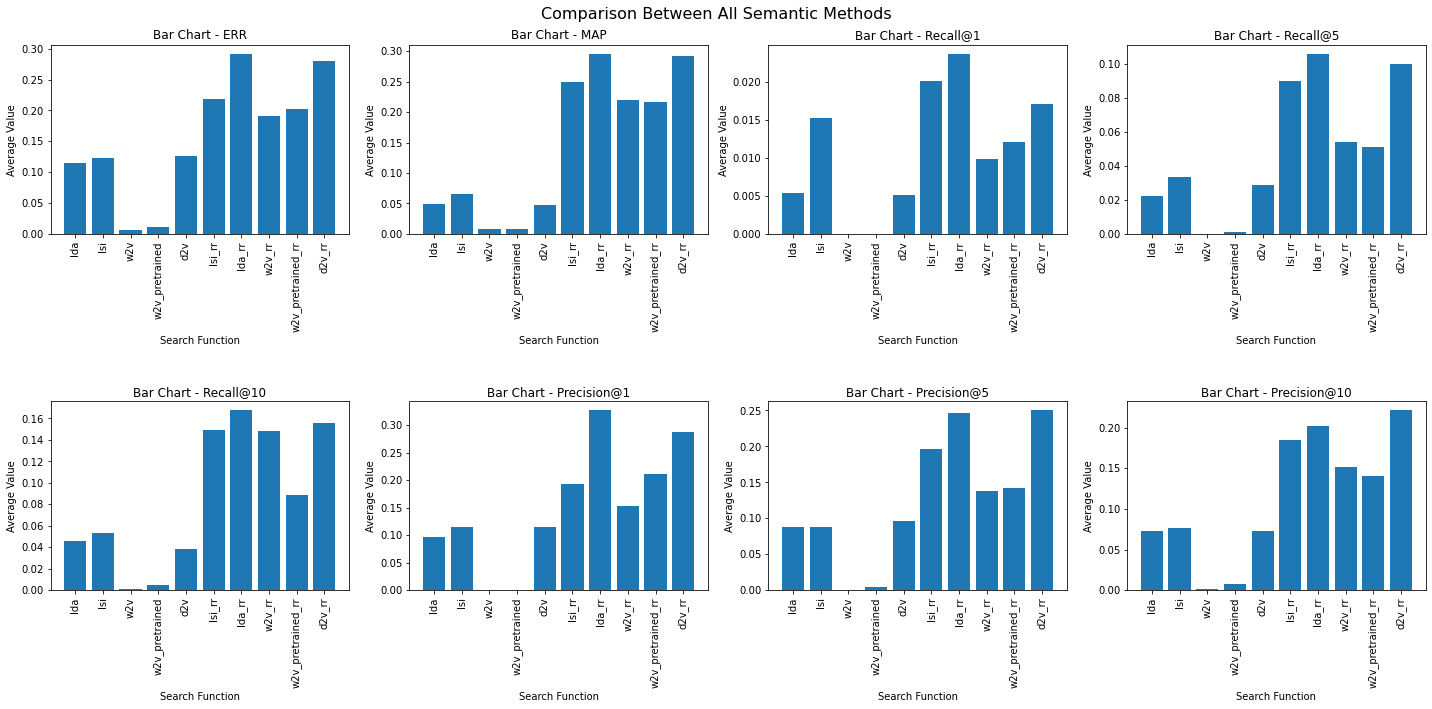

In [102]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Comparison Between All Semantic Methods', fontsize=16)

for i, (selected_metric, funct) in enumerate(list_of_metrics):
    results_fn = []
    for (search_fn, results) in results_search_sem_fns.items():
        for metric, value in results.items():
            if metric == selected_metric:
                results_fn.append((search_fn, value))
    title = f'Bar Chart - {selected_metric}'
    fig.add_subplot(2,4,i+1)
    plt.bar(range(len(results_fn)), [val[1] for val in results_fn])
    plt.xticks(range(len(results_fn)), [val[0] for val in results_fn])
    plt.xticks(rotation=90)
    plt.xlabel('Search Function')
    plt.ylabel('Average Value')
    plt.title(title)

plt.tight_layout(h_pad=4)
plt.show()

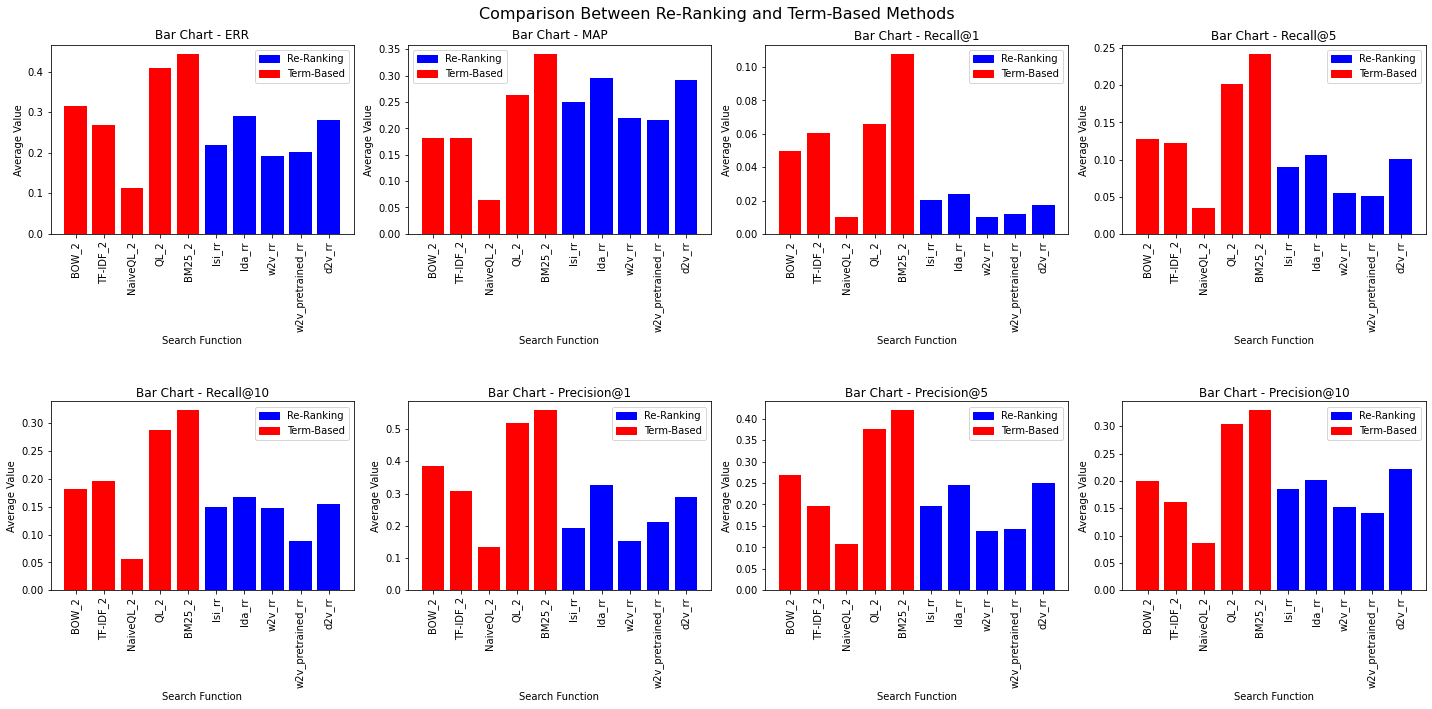

In [103]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Comparison Between Re-Ranking and Term-Based Methods', fontsize=16)
colors_index = {'Re-Ranking':'b', 'Term-Based':'r'}

merged_results = {**results_search_fns, **results_search_sem_fns}
for i, (selected_metric, funct) in enumerate(list_of_metrics):
    results_fn = []
    for (search_fn, results) in merged_results.items():
        for metric, value in results.items():
            if metric == selected_metric and search_fn.endswith('2'):
                results_fn.append((search_fn, value, 'Term-Based'))
            if metric == selected_metric and search_fn.endswith('rr'):
                results_fn.append((search_fn, value, 'Re-Ranking'))
    cols = np.array([colors_index[val[2]] for val in results_fn])
    title = f'Bar Chart - {selected_metric}'
    fig.add_subplot(2,4,i+1)
    plt.bar(range(len(results_fn)), [val[1] for val in results_fn], color=cols)
    plt.xticks(range(len(results_fn)), [val[0] for val in results_fn])
    plt.xticks(rotation=90)
    plt.xlabel('Search Function')
    plt.ylabel('Average Value')
    labels=list(colors_index.keys())
    plt.legend(handles=[plt.Rectangle((0,0),1,1, color=colors_index[label]) for label in labels], labels=labels)
    plt.title(title)

plt.tight_layout(h_pad=4)
plt.show()

### Section 10.2: Summary (20 points)

Your summary should compare methods from Part 1 and Part 2 (only for index set 2). State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations. Consider the availability of data, scalability, domain/type of data, etc.

The experiments have been conducted on the index set 2 and we can present the results for sematic-based approaches. Across all the metrics, we can observe that the best performing methods are the ones that involve re-ranking. The worst performing search methods are both Word2Vec and Word2Vec Pretrained. The other 3 semantic methods considered, LSI, LDA and Doc2Vec, have a similar performance except for when we are considering Recall@1.

It is expected for Word2Vec to not perform as well as the other semantic-based methods due to the fact that the model gives a vector representation per word which is then averaged for the whole document. In our case, this imposes a problem for two reasons. Firstly, not all the documents in our dataset have an abstract, therefore the representation of a document without it can hold less information. Secondly, when using the averaging of the word vectors, their order in the sentence is lost and, furthermore, it is not always the case that all the words carry the same weight for the overall meaning of the document. Therefore, as seen in the bar charts, the methods that give representations for the whole document are more competitive. Overall, Doc2Vec re-ranking and LDA re-ranking have similar performance compared to its competitors. Doc2Vec is expected to perform well considering that it has a more complex approach using stochastic gradient descent and a neural network architecture which can handle the dependencies between the words and paragraphs better. One of the main differences between LSI and LDA is that LSI has at its core a Vector Language Model, whereas LDA is based on a distribution over topics where even if a query is not explicitly present in the document, it can still retrieve the document if they have the same topic. Thus, when we are taking into consideration the reranking cases, we can see that LDA outperforms LSI in all metrics and D2V outperforms LDA for Precision@10 and Precision@5. From the analysis we can see that D2V tends to be more precise in the documents that it finds despite missing some relevant ones, whereas LDA tends to find more relevant documents. This is expected, if we think that LDA takes into consideration the topic of every document, but it can also have more false positives if we are asking for more than 5 documents to retrieve. 

Moreover, when comparing the term-based approaches with the re-ranking semantic-based ones, we can see that BM25 continues to outperform all other methods for all the metrics. We believe that another reason that the sematic approaches are not performing at the same level is the fact that they require more substantial data to be trained on and, in our case, the data is limited. The documents that we are working on are technical and contain scientific information; thus, when doing a query search, it is possible that exact matches between documents and the query are preferred rather than all other possible combinations. The semantic-based approaches also suffer from high computational time even in re-ranking methods compared to BM25, which provides another reason why it is considered one of the most effective and state-of-the-art approaches. When taking into consideration the order in which the documents are retrieved by the system, we can see that the reranking methods are coming closer to the performance of the term-based methods. Considering that usually in web-based applications, the rank plays a significant role, one can conclude that with enough data semantic based methods can outperform and provide more useful information.
